In [ ]:
import pandas as pd
import numpy as np
import glob
from enum import Enum
from datetime import datetime, date, timedelta

class Symnbol(Enum):
    SPX = 'SPX'
    SPY = 'SPY'
    XSP = 'XSP'
    QQQ = 'QQQ'
    RUT = 'RUT'
    NDX = 'NDX'
    AAPL = 'AAPL'
    TSLA = 'TSLA'

class TradeType(Enum):
    Butterfly = 'Butterfly'
    IronCondor = 'Iron Condor'
    Vertical = 'Vertical'
    Sonar = 'Sonar'

trade_legs = {
    TradeType.Butterfly: [1, -2, 1],
    TradeType.IronCondor: [-1, 1, -1, 1],
    TradeType.Vertical: [1, -1],
    TradeType.Sonar: [-1, 1, -1, 1],
}

# Map symbols to integer IDs
symbol_to_id = {symbol.value: idx for idx, symbol in enumerate(Symnbol)}
# Reverse mapping from IDs to symbols
id_to_symbol = {idx: symbol.value for idx, symbol in enumerate(Symnbol)}

# Map trade types to integer IDs
trade_type_to_id = {trade_type.value: idx for idx, trade_type in enumerate(TradeType)}
# Reverse mapping from IDs to trade types
id_to_trade_type = {idx: trade_type.value for idx, trade_type in enumerate(TradeType)}

# load data/raw/magic/*.csv files into a single pandas DataFrame

profits_files = glob.glob('data/results/magic/profits/*.csv')
df_profits = {file.split('/')[-1].split(' ')[1].split('-')[0]: pd.read_csv(file) for file in profits_files}

trades_files = glob.glob('data/results/magic/trades/*.csv')
df_trades = {file.split('/')[-1].split(' ')[1].split('-')[0]: pd.read_csv(file) for file in trades_files}

df_days = []

# Loop through both dictionaries based on matching keys
for key in df_profits.keys() & df_trades.keys():
    dfp = df_profits[key]
    dft = df_trades[key]

    # Remove rows where 'Name' is NaN
    dfp = dfp[dfp['Name'].notna()].copy()

    dfp['DateTime'] = pd.to_datetime(dfp['Day'], format='%m-%d-%Y') + pd.to_timedelta(dfp['Hour'] + ':00')
    dft['DateTime'] = pd.to_datetime(dft['Date'], format='mixed') + pd.to_timedelta(dft['Time'] + ':00')

    mindt_t = dft['DateTime'].min()
    mindt_p = dfp['DateTime'].min()
    delta = mindt_p.hour - mindt_t.hour

    dft['DateTime'] = dft['DateTime'] + timedelta(hours=delta)

    dfp.drop(columns=['Day', 'Hour', 'Predicted', 'Low', 'High', 'Closed', 'Stop', 'Managed', 'Premium', 'Risk', 'Reward'], inplace=True)
    dft.drop(columns=['Date', 'Time', 'Source', 'ExpectedMove', 'Low', 'High', 'Target1', 'Target2', 'Predicted', 'Trade'], inplace=True)
    
    # Merge dfp and dft on DateTime, Symbol, Name
    df = pd.merge(dft, dfp, on=['DateTime', 'Symbol', 'Name'], how='inner', suffixes=('_trade', '_profit'))

    # Sort by Date and preserve original order for same dates
    df = df.sort_values(by=['DateTime']).reset_index(drop=True)

    # Identify blocks of consecutive rows. A block is defined as a group of consecutive rows with different Symbol and/or Name values.
    # A new block starts when a Symbol, Name pair have already been seen in the current block.
    # Assign a number to each block in a new column 'Block'.
    df['Block'] = 0
    seen_pairs = set()
    block_number = 0
    for idx, row in df.iterrows():
        pair = (row['Symbol'], row['Name'])
        if pair in seen_pairs:
            block_number += 1
            seen_pairs = set()
        df.at[idx, 'Block'] = block_number
        seen_pairs.add(pair)
    
    # Set the DateTime column to be the maximum value for each block
    df['DateTime'] = df.groupby('Block')['DateTime'].transform('max')

    # Round date time down to the nearest 5-minute interval
    df['DateTime'] = df['DateTime'].dt.floor('5min')

    # Group by DateTime and find the minimum Block value for each DateTime
    min_blocks = df.groupby('DateTime')['Block'].min().reset_index()
    min_blocks.rename(columns={'Block': 'MinBlock'}, inplace=True)

    # Merge to get the MinBlock for each row
    df = df.merge(min_blocks, on='DateTime', how='left')

    # Keep only rows where Block equals MinBlock
    df = df[df['Block'] == df['MinBlock']]

    # Drop the temporary MinBlock column
    df.drop(columns=['MinBlock', 'Block'], inplace=True)
        
    df_days.append(df) 

df_data = pd.concat(df_days, ignore_index=True).sort_values(by=['DateTime']).reset_index(drop=True)

# Remove any Butterfly trades where Strike2 is not equidistant from Strike1 and Strike3
df_data = df_data[~((df_data['Name'] == 'Butterfly') &
                    ((df_data['Strike2'] - df_data['Strike1']) != (df_data['Strike3'] - df_data['Strike2'])))]


# Optional: Remove all butterfly trades
# df_data = df_data[df_data['Name'] != 'Butterfly'].copy()

# Remove 04-07-2025 trades
df_data = df_data[~((df_data['DateTime'].dt.date == date(2025, 4, 7)))]


# from FedTools import MonetaryPolicyCommittee
# fomc = MonetaryPolicyCommittee()
# fed_dates = fomc.find_statements()

# # Optional: Remove trades on FOMC dates (fed_dates.index)
# df_data = df_data[~df_data['DateTime'].dt.date.isin(fed_dates.index.date)]

# Remove where Strike1 .. Strike4 are not whole numbers, if they are not NaN
df_data = df_data[
    ~(((df_data['Strike1'] % 1 != 0) & df_data['Strike1'].notna()) |
      ((df_data['Strike2'] % 1 != 0) & df_data['Strike2'].notna()) |
      ((df_data['Strike3'] % 1 != 0) & df_data['Strike3'].notna()) |
      ((df_data['Strike4'] % 1 != 0) & df_data['Strike4'].notna()))
].copy()


# NEW: Remove trades where any required leg's Bid or Ask is zero based on trade Name
leg_count_map = {
    'Butterfly': 3,
    'Iron Condor': 4,
    'Vertical': 2,
    'Sonar': 4,
}

# Start with all rows kept; will set False for rows to remove
keep_mask = np.ones(len(df_data), dtype=bool)

# For each possible leg, if the trade type requires that leg then ensure both Bid and Ask are non-zero
for i in range(1, 5):
    leg_required = df_data['Name'].map(lambda nm: leg_count_map.get(nm, 4) >= i)
    bid_zero = df_data.get(f'Bid{i}') == 0
    ask_zero = df_data.get(f'Ask{i}') == 0
    # If leg is required and either bid or ask is zero -> mark for removal
    remove_i = leg_required & (bid_zero | ask_zero)
    keep_mask &= ~remove_i.values

df_data = df_data[keep_mask].copy()

# Indicates how far from the mid price we can buy/sell the options.
# At 0% slippage we buy/sell at the mid price.
# At 100% slippage we buy at the Ask price and sell at the Bid price.
SLIPPAGE_PERCENT = 0.0

df_data['Premium_orig'] = df_data['Premium'].copy()

# Recalculate the Premium column based on the Bid and Ask prices and the SLIPPAGE_PERCENT. Round to 2 decimal places towards the mid price.
# Define multipliers for each leg based on trade type, padded to 4 legs with 0 for missing legs
multipliers = {
    'Butterfly': [1, -2, 1, 0],
    'Iron Condor': [-1, 1, -1, 1],
    'Vertical': [-1, 1, 0, 0],
    'Sonar': [-1, 1, -1, 1]
}
df_data['Multiplier1'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[0])
df_data['Multiplier2'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[1])
df_data['Multiplier3'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[2])
df_data['Multiplier4'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[3])

# Compute mid prices
df_data['Mid1'] = (df_data['Bid1'] + df_data['Ask1']) / 2
df_data['Mid2'] = (df_data['Bid2'] + df_data['Ask2']) / 2
df_data['Mid3'] = (df_data['Bid3'] + df_data['Ask3']) / 2
df_data['Mid4'] = (df_data['Bid4'] + df_data['Ask4']) / 2

# Compute effective prices with slippage and round them — do both in one loop
for i in [1, 2, 3, 4]:
    eff_col = f'Effective{i}'
    mid_col = f'Mid{i}'
    bid_col = f'Bid{i}'
    ask_col = f'Ask{i}'
    mult_col = f'Multiplier{i}'

    # Compute effective price depending on the multiplier sign (buy at worse price for positive mult,
    # sell at worse price for negative mult; zero multiplier => 0)
    df_data[eff_col] = np.where(
        df_data[mult_col] > 0,
        df_data[mid_col] + SLIPPAGE_PERCENT * (df_data[ask_col] - df_data[mid_col]),
        np.where(
            df_data[mult_col] < 0,
            df_data[mid_col] - SLIPPAGE_PERCENT * (df_data[mid_col] - df_data[bid_col]),
            0.0,
        ),
    )

    # Round effective prices to 2 decimal places towards the mid price (preserve .005 tie-breaking)
    r = df_data[eff_col].round(2)
    mask_flat = (df_data[eff_col] - r).abs() == 0.005
    df_data[eff_col] = np.where(
        mask_flat & (r > df_data[mid_col]), r - 0.01,
        np.where(mask_flat & (r < df_data[mid_col]), r + 0.01, r)
    )

# Compute net premium
df_data['Premium'] = (
    df_data['Multiplier1'] * df_data['Effective1'] +
    df_data['Multiplier2'] * df_data['Effective2'] +
    df_data['Multiplier3'] * df_data['Effective3'] +
    df_data['Multiplier4'] * df_data['Effective4']
)

# Drop temporary columns
df_data.drop(columns=['Multiplier1', 'Multiplier2', 'Multiplier3', 'Multiplier4', 'Mid1', 'Mid2', 'Mid3', 'Mid4', 'Effective1', 'Effective2', 'Effective3', 'Effective4'], inplace=True)

df_data['Premium_calc'] = df_data['Premium'].copy()


# Recalculate Risk based on trade type:
# Butterfly: Risk = Premium * 100 (debit position)
# Iron Condor, Sonar: Risk = (Width of wider spread + Premium) * 100 (credit position, premium is negative)
# Vertical: Risk = Width of the spread * 100 + Premium (credit position, premium is negative)
def calculate_risk(row):
    if row['Name'] == 'Butterfly':
        return row['Premium'] * 100
    elif row['Name'] == 'Iron Condor' or row['Name'] == 'Sonar':
        width1 = abs(row['Strike2'] - row['Strike1'])
        width2 = abs(row['Strike4'] - row['Strike3'])
        wider_width = max(width1, width2)
        return (wider_width + row['Premium']) * 100
    elif row['Name'] == 'Vertical':
        width = abs(row['Strike2'] - row['Strike1'])
        return (width + row['Premium']) * 100
    else:
        return row['Risk']  # Fallback to original Risk if trade type is unknown

df_data['Risk_orig'] = df_data['Risk'].copy()
df_data['Risk'] = df_data.apply(calculate_risk, axis=1)

# Remove rows where Risk is negative or zero
df_data = df_data[df_data['Risk'] > 0].copy()

# Calculate a Profit column. The original profit is in the "Raw" column. Need to adjust based on the difference in Risk_orig and Risk
# Profit = Raw + Risk_orig - Risk
df_data['Profit'] = df_data['Raw'] + df_data['Risk_orig'] - df_data['Risk']

settlement_type = {
    'SPX': 'Cash',
    'SPY': 'Physical',
    'XSP': 'Cash',
    'QQQ': 'Physical',
    'RUT': 'Cash',
    'NDX': 'Cash',
    'AAPL': 'Physical',
    'TSLA': 'Physical',
}

COMMISSION_PER_CONTRACT = 1.15  # $0.85 per contract

# Calculate commissions based on trade type and number of contracts (assume 1 contract per leg) and settlement type.
# For cash we only pay the commission once, for physical we pay it twice (opening and closing)
def calculate_commission(row):
    num_legs = leg_count_map.get(row['Name'], 4)
    base_commission = num_legs * COMMISSION_PER_CONTRACT

    # Cash-settled: pay only opening commission
    if settlement_type.get(row['Symbol'], 'Physical') == 'Cash':
        return base_commission  # Pay once for cash settled

    # Physical-settled: pay opening commission for all legs, plus closing commission
    # only for legs that are in-the-money at EOD.
    closing_price = row.get('Closing')  # underlying closing price at EOD
    if pd.isna(closing_price):
        # If no closing price available, conservatively assume no closing commissions
        closing_commission = 0.0
    else:
        closing_commission = 0.0
        # Only consider the legs that the trade uses (1..num_legs)
        for i in range(1, num_legs + 1):
            strike_col = f'Strike{i}'
            type_col = f'Type{i}'
            strike = row.get(strike_col)
            typ = row.get(type_col)

            # skip missing data
            if pd.isna(strike) or pd.isna(typ):
                continue

            typ_upper = str(typ).upper()
            # CALL is ITM if closing_price > strike
            if typ_upper.startswith('C'):
                if closing_price > strike:
                    closing_commission += COMMISSION_PER_CONTRACT
            # PUT is ITM if closing_price < strike
            elif typ_upper.startswith('P'):
                if closing_price < strike:
                    closing_commission += COMMISSION_PER_CONTRACT
            else:
                # Unknown type: skip
                continue

    # total = opening commissions + closing commissions only for ITM legs
    return base_commission + closing_commission
    
df_data['Commission'] = df_data.apply(calculate_commission, axis=1)
df_data['NetProfit'] = df_data['Profit'] - df_data['Commission']

import pandas as pd
import numpy as np

# Assuming leg_count_map and settlement_type are defined elsewhere as in the original code

COMMISSION_PER_CONTRACT = 0.85  # $0.85 per contract

def calculate_max_itm(row):
    num_legs = leg_count_map.get(row['Name'], 4)
    legs = []
    for i in range(1, num_legs + 1):
        strike_col = f'Strike{i}'
        type_col = f'Type{i}'
        strike = row.get(strike_col)
        typ = row.get(type_col)
        if pd.isna(strike) or pd.isna(typ):
            continue
        legs.append((strike, typ))
    
    if not legs:
        return 0.0
    
    strikes = [leg[0] for leg in legs if not pd.isna(leg[0])]
    if not strikes:
        return 0.0
    
    unique_strikes = sorted(set(strikes))
    min_s = min(unique_strikes)
    max_s = max(unique_strikes)
    test_points = [min_s - 1]
    for j in range(len(unique_strikes) - 1):
        mid = (unique_strikes[j] + unique_strikes[j + 1]) / 2
        test_points.append(mid)
    test_points.append(max_s + 1)
    
    max_count = 0
    for s in test_points:
        count = 0
        for strike, typ in legs:
            typ_upper = str(typ).upper()
            if typ_upper.startswith('C'):
                if s > strike:
                    count += 1
            elif typ_upper.startswith('P'):
                if s < strike:
                    count += 1
        max_count = max(max_count, count)
    
    return max_count

def calculate_max_commission(row):
    num_legs = leg_count_map.get(row['Name'], 4)
    base_commission = num_legs * COMMISSION_PER_CONTRACT
    sett = settlement_type.get(row['Symbol'], 'Physical')
    if sett == 'Cash':
        return base_commission
    else:
        max_itm = calculate_max_itm(row)
        closing_commission = max_itm * COMMISSION_PER_CONTRACT
        return base_commission + closing_commission

df_data['NetRisk'] = df_data['Risk'] + df_data.apply(calculate_max_commission, axis=1)

df_data['Weekday'] = df_data['DateTime'].dt.weekday  # Monday=0, Sunday=6


In [ ]:
# Optional: Remove TSLA and AAPL trades
df_data = df_data[~df_data['Symbol'].isin(['TSLA', 'AAPL'])]

# Remove rows from the last hour of trading (>= 15:00)
df_data = df_data[df_data['DateTime'].dt.hour < 15]

df_processed = pd.DataFrame()

df_processed['DateInt'] = df_data['DateTime'].apply(lambda x: x.year * 10000 + x.month * 100 + x.day)
df_processed['TimeInt'] = df_data['DateTime'].apply(lambda x: x.hour * 100 + (x.minute // 5) * 5)
df_processed['SymbolID'] = df_data['Symbol'].map(symbol_to_id)
df_processed['TradeID'] = df_data['Name'].map(trade_type_to_id)
df_processed['Weekday'] = df_data['Weekday']

df_processed['ProfitPercent'] = np.where(df_data['NetRisk'] == 0, 0, df_data['NetProfit'] / (df_data['NetRisk']))


In [ ]:
df_sorted = df_data.copy()
df_sorted['ProfitPercent'] = np.where(df_data['Risk'] == 0, 0, df_data['NetProfit'] / (df_data['NetRisk']))
# df_sorted = df_sorted.sort_values(by=['ProfitPercent'], ascending=False)
df_sorted = df_sorted[(df_sorted['Symbol'] == 'SPY') & (df_sorted['Name'] == 'Butterfly') & (df_sorted['DateTime'].dt.hour == 11) & (df_sorted['DateTime'].dt.minute == 10)]
df_sorted = df_sorted.sort_values(by=['ProfitPercent'], ascending=False)
df_sorted[['Symbol', 'Name', 'DateTime', 'Risk', 'NetRisk', 'Risk_orig', 'Raw', 'Profit', 'NetProfit', 'ProfitPercent', 'Closing', 'Trade']].head(20)



In [ ]:
import torch

# Load the first 4 columns (indices) into an int tensor
indices_tensor = torch.tensor(df_processed.iloc[:, :4].values, dtype=torch.int32, device='cuda')

# Load ProfitPercent separately
profit_percent = torch.tensor(df_processed['ProfitPercent'].values, dtype=torch.float32, device='cuda')

# Get unique sorted values for each of the first 4 columns
unique_dates = torch.unique(indices_tensor[:, 0]).sort().values
unique_times = torch.unique(indices_tensor[:, 1]).sort().values
unique_symbols = torch.unique(indices_tensor[:, 2]).sort().values
unique_trades = torch.unique(indices_tensor[:, 3]).sort().values

# Get the df_processed['Weekday'] values for each unique date
date_to_weekday = {date: weekday for date, weekday in zip(df_processed['DateInt'], df_processed['Weekday'])}
unique_weekdays = torch.tensor([date_to_weekday[date.item()] for date in unique_dates], dtype=torch.int32, device='cuda')

# Initialize 4D tensor with shape based on unique counts
profits = torch.zeros((len(unique_dates), len(unique_times), len(unique_symbols), len(unique_trades)), dtype=torch.float32, device='cuda')

# Populate the tensor with ProfitPercent values using vectorized indexing
date_indices = torch.bucketize(indices_tensor[:, 0], unique_dates)
time_indices = torch.bucketize(indices_tensor[:, 1], unique_times)
symbol_indices = torch.bucketize(indices_tensor[:, 2], unique_symbols)
trade_indices = torch.bucketize(indices_tensor[:, 3], unique_trades)

profits[date_indices, time_indices, symbol_indices, trade_indices] = profit_percent
win_rate = (profits > 0).float().mean(dim=0)
profits_backup = profits.clone()


In [2]:
import torch

# --- Frank–Wolfe with exact 1-D line search on {x>=0, sum<=1} ------------------
@torch.compile()
def maximise_f_frank_wolfe_leq1_v2(
    A: torch.Tensor,
    *,
    max_iter: int = 100_000,
    tol_gap: float | None = None,
    rel_gap: float = 1e-8,
    tol_df: float | None = None,
    patience: int = 20,
    eps: float = 1e-12,
    max_ls_it: int = 40,
):
    """
    Maximise f(x)=sum_i log(1 + (A x)_i) over {x>=0, sum(x)<=1} by Frank–Wolfe.
    """
    finfo = torch.finfo(A.dtype)
    if tol_gap is None: tol_gap = 100 * finfo.eps
    if tol_df  is None: tol_df  = 10 * finfo.eps

    _, n = A.shape

    x = torch.zeros(n, device=A.device, dtype=A.dtype)

    def fval(x):
        return torch.log1p(torch.clamp(A @ x, min=-1 + eps)).sum()

    f_prev = fval(x)
    stall = 0
    steps = 0
    gap = torch.tensor(float('inf'), device=A.device, dtype=A.dtype)

    for _ in range(max_iter):
        s = A @ x                         # (m,)
        w = 1.0 / torch.clamp(1.0 + s, min=eps)
        g = A.t().matmul(w)               # (n,) gradient wrt x

        # pick vertex v = argmax_{v in {0, e_j}} <g, v>  (0 is new)
        k = int(torch.argmax(g))
        if g[k] <= 0:
            v = torch.zeros_like(x)       # CHANGED: choose the zero-vertex if all g_j <= 0
        else:
            v = torch.zeros_like(x); v[k] = 1.0

        # FW gap for maximisation: gap = <g, v - x>  (>=0 by construction)
        gap = (g.dot(v) - g.dot(x))

        # stop on absolute/relative gap
        f_now = f_prev
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_now))):
            break

        # Line search on phi(gamma) = sum_i log(1 + s_i + gamma * t_i)
        t_vec = A @ (v - x)

        def dphi(gamma: float):
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            return torch.sum(t_vec / denom)

        d0 = dphi(0.0)                    # equals gap
        d1 = dphi(1.0)

        if d1 > 0.0:
            gamma = 1.0                   # jump fully to the chosen vertex
        elif d0 <= 0.0:
            gamma = 0.0                   # already optimal along this direction
        else:
            lo, hi = 0.0, 1.0             # bisection to solve dphi(gamma)=0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)

        # Feasible convex update keeps sum<=1 automatically
        x = (1.0 - gamma) * x + gamma * v

        # Stall guard on |Δf|
        f_new = fval(x)
        if abs(f_new - f_prev) <= tol_df:
            stall += 1
            if stall >= patience:
                break
        else:
            stall = 0
        f_prev = f_new
        steps += 1
   
    print(f"steps={steps}, gap={gap.item():.3e}, fval={f_prev.item():.6e}")
   
    return x, f_prev.item()


In [ ]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Dict, Any

@torch.no_grad()
def fw_solve_l1ball_static_ratio(
    A: torch.Tensor,                       # (m, n)
    *,
    removed: Optional[torch.Tensor] = None,# (n,) bool mask of "deleted" cols
    x0: Optional[torch.Tensor] = None,     # feasible warm start
    max_iter: int = 100_000,
    tol_gap: Optional[float] = None,
    rel_gap: float = 1e-8,
    eps: float = 1e-12,                    # guard for log domain: 1+s >= eps
    sigma_eps: float = 1e-12,              # guard for std: sqrt(var + sigma_eps)
    max_ls_it: int = 40,
) -> Tuple[torch.Tensor, float, Dict[str, Any]]:
    """
    Nonconvex Frank–Wolfe for F(x)=sum(log1p(Ax)) / (std(Ax)+1), over {x>=0, sum(x)<=1}.
    Static shapes, no in-place. Use multiple restarts for better solutions.
    """
    device, dtype = A.device, A.dtype
    m, n = A.shape
    finfo = torch.finfo(dtype)
    if tol_gap is None:
        tol_gap = 100 * finfo.eps
    neg_inf = torch.tensor(float("-inf"), device=device, dtype=dtype)

    removed = removed if removed is not None else torch.zeros(n, device=device, dtype=torch.bool)
    keep = (~removed).to(dtype)

    # Safe init (avoid (-inf)*0): use zeroed A for s and for gradient products
    A_zero_removed = torch.where(removed.unsqueeze(0), torch.zeros_like(A), A)

    # ---- init x, s = A x ----
    if x0 is None:
        x = torch.zeros(n, device=device, dtype=dtype)
        s = torch.zeros(m, device=device, dtype=dtype)
    else:
        x = torch.clamp(x0.to(device=device, dtype=dtype), min=0)
        x = x * keep
        sx = x.sum()
        x = torch.where(sx > 1 + 1e-12, x / sx, x)
        s = A_zero_removed.matmul(x)

    # helpers
    def f_N_D(s_vec: torch.Tensor):
        # Numerator, denominator, std pieces
        s_clamped = torch.clamp(s_vec, min=-1 + eps)
        N = torch.log1p(s_clamped).sum()
        c = s_vec - s_vec.mean()
        var = c.square().mean()
        sigma = torch.sqrt(var + sigma_eps)
        D = sigma + 1.0
        return N, D, c, sigma

    def f_value(s_vec: torch.Tensor) -> float:
        N, D, _, _ = f_N_D(s_vec)
        return (N / D).item()

    # current value
    f_val = f_value(s)
    gap = float("inf")
    it = 0

    for it in range(max_iter):
        # grad wrt s
        N, D, c, sigma = f_N_D(s)
        grad_N = 1.0 / torch.clamp(1.0 + s, min=eps)          # (m,)
        grad_sigma = c / (m * sigma)                           # (m,)
        grad_s = grad_N / D - (N / (D * D)) * grad_sigma       # (m,)

        # g = A^T grad_s using ZEROED columns to avoid (-inf)*0
        g = A_zero_removed.t().matmul(grad_s)                  # (n,)
        # forbid removed cols in LMO
        g = torch.where(removed, neg_inf, g)

        # LMO over {0, e1,...,en}
        g_max_val, k = torch.max(g, dim=0)
        v_is_zero = g_max_val.item() <= 0.0

        # Nonconvex FW gap (stationarity measure)
        g_for_dot = torch.where(x > 0, g, torch.zeros_like(g)) # avoid (-inf)*0
        gap = max(g_max_val.item(), 0.0) - (g_for_dot * x).sum().item()
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_val))):
            break

        # Direction t = A@(v - x) (no explicit v)
        t_vec = (-s) if v_is_zero else (A[:, k] - s)

        # 1-D line search on gamma ∈ [0,1]
        def N_D_at(gamma: float):
            sg = s + gamma * t_vec
            return f_N_D(sg)

        def dphi(gamma: float) -> float:
            # derivative along t: (N' D - N D')/D^2
            Ng, Dg, cg, sigmag = N_D_at(gamma)
            # N' = sum t_i / (1 + s_i + gamma t_i)
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            Nprime = torch.sum(t_vec / denom)
            # D' = <c(gamma), t> / (m * sigma(gamma))
            Dprime = torch.dot(cg, t_vec) / (m * sigmag)
            return ((Nprime * Dg - Ng * Dprime) / (Dg * Dg)).item()

        def phi(gamma: float) -> float:
            return f_value(s + gamma * t_vec)

        d0, d1 = dphi(0.0), dphi(1.0)
        if d1 > 0.0:
            gamma = 1.0
        elif d0 < 0.0:
            gamma = 0.0
        elif d0 > 0.0 and d1 < 0.0:
            # bisection on derivative root
            lo, hi = 0.0, 1.0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)
        else:
            # fallback: pick best among a tiny grid (robust for non-concave case)
            cand = torch.tensor([0.0, 0.5, 1.0], device=device, dtype=dtype)
            vals = torch.tensor([phi(float(c)) for c in cand], device=device, dtype=dtype)
            gamma = float(cand[torch.argmax(vals)])

        # functional updates (no in-place)
        if v_is_zero:
            x = (1.0 - gamma) * x
        else:
            one_hot = F.one_hot(k, num_classes=n).to(dtype=dtype, device=device)
            x = (1.0 - gamma) * x + gamma * one_hot

        s = s + gamma * t_vec
        f_val = f_value(s)

    info = {"iters": it + 1, "gap": gap, "sumx": x.sum().item()}
    return x, f_val, info


In [ ]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Dict, Any

# ----------------------- 1) FW solver (static-shape, no in-place) -----------------------

@torch.no_grad()
def fw_solve_l1ball_static(
    A_masked: torch.Tensor,                 # A with removed columns set to -inf (same shape as A)
    *,
    removed: Optional[torch.Tensor] = None, # (n,) bool mask of removed columns
    x0: Optional[torch.Tensor] = None,      # (n,) warm start (feasible: x>=0, sum<=1)
    max_iter: int = 100_000,
    tol_gap: Optional[float] = None,        # absolute dual-gap tol
    rel_gap: float = 1e-8,                  # relative dual-gap tol
    eps: float = 1e-12,                     # guard for log domain
    max_ls_it: int = 40,                    # bisection steps
) -> Tuple[torch.Tensor, float, Dict[str, Any]]:
    """
    Maximise f(x)=Σ log(1 + (A x)_i) over {x>=0, Σx<=1} via Frank–Wolfe
    using fixed shapes (no slicing) and no in-place ops.
    `A_masked` must have -inf in removed columns; others unchanged.
    """

    device, dtype = A_masked.device, A_masked.dtype
    m, n = A_masked.shape
    finfo = torch.finfo(dtype)
    if tol_gap is None:
        tol_gap = 100 * finfo.eps

    neg_inf = torch.tensor(float("-inf"), device=device, dtype=dtype)

    def f_from_s(s: torch.Tensor) -> torch.Tensor:
        return torch.log1p(torch.clamp(s, min=-1 + eps)).sum()

    # ---------- initialise x & s (careful to avoid (-inf)*0) ----------
    if x0 is None:
        x = torch.zeros(n, device=device, dtype=dtype)
        s = torch.zeros(m, device=device, dtype=dtype)
    else:
        x = torch.clamp(x0.to(device=device, dtype=dtype), min=0.0)
        # zero out removed coords in x (functional)
        if removed is not None:
            x = x * (~removed).to(dtype)
        sx = x.sum()
        x = torch.where(sx > 1 + 1e-12, x / sx, x)

        # To compute s=A@x without NaNs, zero removed columns just for this product
        if removed is None:
            A_for_s = A_masked  # no -inf present => safe
        else:
            A_for_s = torch.where(removed.unsqueeze(0), torch.zeros_like(A_masked), A_masked)
        s = A_for_s.matmul(x)

    f_val = f_from_s(s).item()
    gap = float("inf")
    it = 0

    for it in range(max_iter):
        # grad g = A^T * (1 / (1 + s))
        w = 1.0 / torch.clamp(1.0 + s, min=eps)
        g = A_masked.t().matmul(w)  # (n,)

        # Exclude removed columns from LMO by forcing g=-inf there
        if removed is not None and removed.any():
            g = torch.where(removed, neg_inf, g)

        # LMO over {0, e1,...,en}
        g_max_val, k = torch.max(g, dim=0)
        v_is_zero = g_max_val.item() <= 0.0

        # Duality gap: max(0, max_j g_j) - <g, x>, but avoid (-inf)*0
        g_for_dot = torch.where(x > 0, g, torch.zeros_like(g))
        gap = max(g_max_val.item(), 0.0) - (g_for_dot * x).sum().item()
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_val))):
            break

        # Direction t = A@(v-x) (without forming v explicitly)
        t_vec = (-s) if v_is_zero else (A_masked[:, k] - s)

        # Exact line search by bisection on derivative dφ(γ)
        def dphi(gamma: float) -> float:
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            return torch.sum(t_vec / denom).item()

        d0 = dphi(0.0)
        d1 = dphi(1.0)
        if d1 > 0.0:
            gamma = 1.0
        elif d0 <= 0.0:
            gamma = 0.0
        else:
            lo, hi = 0.0, 1.0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)

        # Update x (functional)
        if v_is_zero:
            x = (1.0 - gamma) * x
        else:
            one_hot = F.one_hot(k, num_classes=n).to(dtype=dtype, device=device)
            x = (1.0 - gamma) * x + gamma * one_hot

        # Update s via rank-1 update (no matmul, no in-place)
        s = s + gamma * t_vec
        f_val = f_from_s(s).item()

    info = {"iters": it + 1, "gap": gap, "sumx": x.sum().item()}
    return x, f_val, info


# ------------------- 2) Outer iterative prune (static-shape wrapper) --------------------

@torch.no_grad()
def fw_iterative_prune_static(
    A: torch.Tensor,                       # (m, n) original matrix
    *,
    tau: Optional[float] = None,           # prune if min positive mass < tau
    max_nnz: Optional[int] = None,         # enforce nnz <= max_nnz
    max_outer: Optional[int] = None,       # safety cap on pruning rounds
    # inner FW settings
    tol_gap: Optional[float] = None,
    rel_gap: float = 1e-6,
    inner_max_iter: int = 2000,
    eps: float = 1e-12,
) -> Tuple[torch.Tensor, float, Dict[str, Any]]:
    """
    Static-shape pruning wrapper:
      - Keeps shapes fixed (never slices A).
      - Virtually removes columns by setting them to -inf via a boolean mask.
      - Avoids in-place tensor edits.
    """
    device, dtype = A.device, A.dtype
    m, n = A.shape
    finfo = torch.finfo(dtype)
    if tol_gap is None: tol_gap = 100 * finfo.eps
    if max_outer is None:     max_outer = n

    neg_inf = torch.tensor(float("-inf"), device=device, dtype=dtype)

    removed = torch.zeros(n, device=device, dtype=torch.bool)
    x0 = torch.zeros(n, device=device, dtype=dtype)

    history: Dict[str, Any] = {"removed_idx": [], "round_info": []}
    rounds = 0
    x = x0.clone()
    f_fast = float('-inf')
    info_fast = {}

    while rounds < max_outer:
        rounds += 1

        # Build masked A (no in-place): removed columns -> -inf
        A_masked = torch.where(removed.unsqueeze(0), neg_inf, A)

        # Inner fast FW solve with warm start x0
        x, f_fast, info_fast = fw_solve_l1ball_static(
            A_masked,
            removed=removed,
            x0=x0,
            max_iter=inner_max_iter,
            tol_gap=tol_gap,
            rel_gap=rel_gap,
            eps=eps,
        )

        # Decide if we need to prune one coordinate
        pos_mask = x > 0
        nnz = int(pos_mask.sum().item())

        # Candidate index to remove (global index)
        remove_idx: Optional[int] = None

        # Enforce max_nnz first
        if max_nnz is not None and nnz > max_nnz:
            # pick smallest positive mass
            candidates = torch.where(
                pos_mask, x, torch.full_like(x, float('inf'))
            )
            remove_idx = int(torch.argmin(candidates).item())

        # Else prune by threshold if set
        if remove_idx is None and tau is not None and nnz > 0:
            # global min among positives
            candidates = torch.where(
                pos_mask, x, torch.full_like(x, float('inf'))
            )
            min_val, argmin_idx = torch.min(candidates, dim=0)
            if min_val.item() < tau:
                remove_idx = int(argmin_idx.item())

        # Nothing to prune: do a final tight FW pass and return
        if remove_idx is None:
            return x, f_fast, {
                "outer_rounds": rounds,
                "inner_history": history,
                "final_info": info_fast,
                "stopped_reason": "no_more_pruning",
            }

        # Update removed mask (functional, no in-place)
        remove_onehot = F.one_hot(
            torch.tensor(remove_idx, device=device), num_classes=n
        ).to(dtype=torch.bool)
        removed = torch.logical_or(removed, remove_onehot)

        # Warm start for next round: zero the removed coord(s), keep others
        x0 = x * (~removed).to(dtype)

        # Record history
        history["removed_idx"].append(remove_idx)
        history["round_info"].append(
            {"round": rounds, "removed": remove_idx, "nnz_before": nnz, **info_fast}
        )
        print(f"Round {rounds}: removed idx {remove_idx}, nnz before={nnz}, f_fast={f_fast:.6e}, gap={info_fast['gap']:.6e}")

    out_info = {
        "outer_rounds": rounds,
        "inner_history": history,
        "final_info": info_fast,
        "stopped_reason": "max_outer_reached",
    }
    return x, f_fast, out_info


In [ ]:
from einops import rearrange, repeat

# Rearrange the tensor so that time, symbol and trade dimensions are merged into a batch dimension, and date dimension is the sequence dimension
# profits_thursday = profits[unique_weekdays == 3, :, :, :]
profits = profits_backup.clone()

profits_flat = rearrange(profits, 'd t s tr -> d (t s tr)')
mask = torch.ones_like(profits)

# Keep only Thursday trades in the mask
# mask[unique_weekdays != 3, :, :, :] = 0.0

# mask = mask * (win_rate >= 0.80).unsqueeze(0).float()

# mask = mask * (profits.mean(dim=0) >= 0.0).unsqueeze(0).float()

# mask[-40:, :, :, :] = 0.0

sharpe = (profits.mean(dim=0)) / profits.std(dim=0)
# mask = mask * (sharpe >= 1.5).unsqueeze(0).float()
#sharpe = profits[:-40, :, :, :].mean(dim=0) / profits[:-40, :, :, :].std(dim=0)
# log_profits = torch.log1p(profits * 0.25)
# lp_mean = log_profits.mean(dim=0)
# sharpe = torch.where(lp_mean > 0, lp_mean / log_profits.std(dim=0), lp_mean)
print(f"Sharpe: mean={sharpe.mean().item():.3f}, max={sharpe.max().item():.3f}, min={sharpe.min().item():.3f}")
TOPK = 1
# Keep the top N sharpe trades
topk_vals, topk_idx = torch.topk(sharpe.flatten(), TOPK)
topk_mask = torch.zeros_like(sharpe.flatten())
topk_mask[topk_idx] = 1.0
topk_mask = topk_mask.view(sharpe.shape)
mask = mask * topk_mask.unsqueeze(0).float()


mask = mask * (sharpe >= 0.2).unsqueeze(0).float()

# Keep only trades which have improved in the last 120 days
# sharpe_120 = (profits[-120:, :, :, :].mean(dim=0) + 1.0) / profits[-120:, :, :, :].std(dim=0)
# mask = mask * (sharpe_120 > sharpe + 0.1).unsqueeze(0).float()


#days_n = mask[:,0,0,0].sum().item()
#days_n = profits_flat.shape[0]
mask_flat = rearrange(mask, 'd t s tr -> d (t s tr)')

days_n = mask_flat.max(dim=1).values.sum().item()
print(f"Using {days_n} days of data; Total trades = {mask_flat.sum().item()}, Avg per day = {mask_flat.sum().item()/days_n:.1f}")

# Risk modifier: Multiply negative profits by a risk factor > 1.0 to penalize them more heavily
risk_factor = torch.tensor(1.0, device=profits_flat.device, dtype=profits_flat.dtype)
risk_mod = torch.where(profits_flat < 0.0, risk_factor, 1.0)


In [ ]:
# kelly_flat = maximise_f_frank_wolfe_leq1_v2(profits_flat * mask_flat * risk_mod, max_iter=100000, tol_gap=1.0e-3, tol_df=1e-6)[0]
kelly_flat, _, iter_info = fw_iterative_prune_static(profits_flat * mask_flat * risk_mod + mask_flat - 1.0, tau=0.1, max_nnz=None, inner_max_iter=10000, tol_gap=1e-2, rel_gap=1e-6)

gains = (profits_flat * mask_flat) @ kelly_flat + 1.0
geometric_mean = gains.prod() ** (1.0 / days_n)

# print(f"Annualized profit on capital: {(geometric_mean ** 250 - 1.0) * 100} %")
print(f"Total allocation: {kelly_flat.sum()}, Average daily profit: {geometric_mean}, Non-zero allocations: {kelly_flat.nonzero().size(0)}, Smallest non-zero allocation: {torch.min(kelly_flat[kelly_flat != 0])}")

kelly = rearrange(kelly_flat, '(t s tr) -> t s tr', t=len(unique_times), s=len(unique_symbols), tr=len(unique_trades))

# Print out non-zero allocations in descending order, mapping back to original times, symbols and trade types
non_zero_indices = torch.nonzero(kelly_flat).squeeze(1)
non_zero_values = kelly_flat[non_zero_indices]
sorted_indices = torch.argsort(non_zero_values, descending=True)
if len(sorted_indices.shape) == 0:
    sorted_indices = sorted_indices.unsqueeze(0)

for idx in sorted_indices:
    flat_index = non_zero_indices[idx].item()
    value = non_zero_values[idx].item()
    t = flat_index // (len(unique_symbols) * len(unique_trades))
    s = (flat_index // len(unique_trades)) % len(unique_symbols)
    tr = flat_index % len(unique_trades)
    time_str = f"{int(unique_times[t].item() // 100):02d}:{int(unique_times[t].item() % 100):02d}"
    symbol_str = id_to_symbol[int(unique_symbols[s].item())]
    trade_str = id_to_trade_type[int(unique_trades[tr].item())]
    print(f"Time: {time_str}, Symbol: {symbol_str}, Trade: {trade_str}, Allocation: {value:.6f}")


- Total allocation: 0.9993056654930115, Average daily profit: 1.075233817100525, Non-zero allocations: 5, Smallest non-zero allocation: 0.10272350907325745
- Time: 09:50, Symbol: QQQ, Trade: Butterfly, Allocation: 0.130289
- Time: 10:50, Symbol: SPY, Trade: Butterfly, Allocation: 0.102724
- Time: 12:40, Symbol: QQQ, Trade: Butterfly, Allocation: 0.233800
- Time: 13:25, Symbol: RUT, Trade: Vertical, Allocation: 0.177444
- Time: 14:05, Symbol: SPY, Trade: Vertical, Allocation: 0.355050


In [ ]:
kelly = rearrange(kelly_flat, '(t s tr) -> t s tr', t=len(unique_times), s=len(unique_symbols), tr=len(unique_trades))

# Print out non-zero allocations in descending order, mapping back to original times, symbols and trade types
non_zero_indices = torch.nonzero(kelly)
non_zero_values = kelly_flat[non_zero_indices]


# sorted_indices = torch.argsort(non_zero_values, descending=True)
# for idx in sorted_indices:
#     flat_index = non_zero_indices[idx].item()
#     value = non_zero_values[idx].item()
#     t = flat_index // (len(unique_symbols) * len(unique_trades))
#     s = (flat_index // len(unique_trades)) % len(unique_symbols)
#     tr = flat_index % len(unique_trades)
#     time_str = f"{int(unique_times[t].item() // 100):02d}:{int(unique_times[t].item() % 100):02d}"
#     symbol_str = id_to_symbol[int(unique_symbols[s].item())]
#     trade_str = id_to_trade_type[int(unique_trades[tr].item())]
#     print(f"Time: {time_str}, Symbol: {symbol_str}, Trade: {trade_str}, Allocation: {value:.6f}")

All dates:
- Time: 13:25, Symbol: RUT, Trade: Vertical, Allocation: 0.310823
- Time: 14:05, Symbol: SPY, Trade: Vertical, Allocation: 0.300035
- Time: 12:40, Symbol: QQQ, Trade: Butterfly, Allocation: 0.232771
- Time: 09:50, Symbol: QQQ, Trade: Butterfly, Allocation: 0.155266
-
- Cumulative Gain after 248 days: 11.10396957397461, Average daily gain: 1.009754130005004

In [ ]:
mask_flat[:, non_zero_indices[sorted_indices[-1]]] = 0
mask_flat.shape[1] - mask_flat[0].count_nonzero()

In [ ]:
from einops import rearrange

TESTING_WINDOW = 200
TOPK = 10

profits = profits_backup.clone()

gains = torch.zeros(profits.shape[0] - TESTING_WINDOW, device=profits.device, dtype=profits.dtype)
half_gains = torch.zeros_like(gains)
quarter_gains = torch.zeros_like(gains)
# Walk-forward testing with a rolling window of 100 days

for i in range(TESTING_WINDOW, profits.shape[0]):
    profits_train = profits[:i]
    profits_flat = rearrange(profits_train, 'd t s tr -> d (t s tr)')

    mask = torch.ones_like(profits_train)

    # Keep only the same weekday trades in the mask as the test day
    # mask[unique_weekdays[:i] != unique_weekdays[i]] = 0.0

    # sharpe = (profits_train.mean(dim=0) + 1.0) / profits_train.std(dim=0)
    # mask = mask * (sharpe >= 1.5).unsqueeze(0).float()

    # # Keep only trades which have improved in the last 120 days
    # sharpe_120 = (profits_train[-120:, :, :, :].mean(dim=0) + 1.0) / profits_train[-120:, :, :, :].std(dim=0)
    # mask = mask * (sharpe_120 > sharpe + 0.1).unsqueeze(0).float()

    # log_profits = torch.log1p(profits_train * 0.25)
    # lp_mean = log_profits.mean(dim=0)
    # sharpe = torch.where(lp_mean > 0, lp_mean / log_profits.std(dim=0), lp_mean)
    # Keep the top N sharpe trades
    # topk_vals, topk_idx = torch.topk(sharpe.flatten(), TOPK)
    # topk_mask = torch.zeros_like(sharpe.flatten())
    # topk_mask[topk_idx] = 1.0
    # topk_mask = topk_mask.view(sharpe.shape)
    # mask *= topk_mask.unsqueeze(0).float()

    # mask = mask * (sharpe >= 0.2).unsqueeze(0).float()
    # mask[-50:, :, :, :] = 0.0

    days_n = mask[:,0,0,0].sum().item()
    mask_flat = rearrange(mask, 'd t s tr -> d (t s tr)')

    # Risk modifier: Multiply negative profits by a risk factor > 1.0 to penalize them more heavily
    risk_factor = torch.tensor(1.25, device=profits_flat.device, dtype=profits_flat.dtype)
    risk_mod = torch.where(profits_flat < 0.0, risk_factor, 1.0)
    
    # kelly_flat = maximise_f_frank_wolfe_leq1_v2(profits_flat, max_iter=10000, tol_gap=1.0e-1, tol_df=1e-6)[0]
    kelly_flat, _, iter_info = fw_iterative_prune_static(profits_flat * mask_flat * risk_mod, tau=0.1, max_nnz=None, inner_max_iter=10000, tol_gap=1e-1)

    profits_i_flat = rearrange(profits[i].unsqueeze(0), 'd t s tr -> d (t s tr)')
    gains[i-TESTING_WINDOW] = (profits_i_flat @ kelly_flat) + 1.0
    half_gains[i-TESTING_WINDOW] = (profits_i_flat @ (0.5 * kelly_flat)) + 1.0
    quarter_gains[i-TESTING_WINDOW] = (profits_i_flat @ (0.25 * kelly_flat)) + 1.0

In [ ]:
# profits_flat = rearrange(profits_backup, 'd t s tr -> d (t s tr)')[-160:]
half_gains = profits_flat @ (kelly_flat * 0.25) + 1.0
cumulative_gains = half_gains.cumprod(dim=0)
# cumulative_gains = quarter_gains.cumprod(dim=0)

import matplotlib.pyplot as plt
# Plot using a log scale for y-axis
plt.figure(figsize=(10, 6))
plt.plot(cumulative_gains.cpu().numpy())
plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('Cumulative Gain (log scale)')
plt.title('Cumulative Gain Over Time')
plt.grid(True, which="both", ls="--")
plt.show()

# Calculate max drawdown
running_max = torch.cummax(cumulative_gains, dim=0).values
drawdowns = (cumulative_gains - running_max) / running_max
print(f"Cumulative Gain after {cumulative_gains.size(0)} days: {(cumulative_gains[-1].item()-1.0)*100:.2f}%, Average daily gain: {(cumulative_gains[-1].item() ** (1.0 / cumulative_gains.size(0))-1.0) * 100:.2f}%, Annualized profit on capital: {(cumulative_gains[-1].item() ** (250.0 / cumulative_gains.size(0))-1.0) * 100:.2f}% ")
if len(cumulative_gains) > 120:
    print(f"Cumulative Gain last 120 days: {cumulative_gains[-1].item() / cumulative_gains[-120].item()}, Average daily gain (last 120 days): {(cumulative_gains[-1].item() / cumulative_gains[-120].item()) ** (1.0 / 120)}")
    max_drawdown_120 = drawdowns[-120:].min().item()
else:
    max_drawdown_120 = drawdowns.min().item()
max_drawdown = drawdowns.min().item()
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%, Max Drawdown (last 120 days): {max_drawdown_120 * 100:.2f}%")
max_drawdown_duration = 0
current_duration = 0
for i in range(1, len(drawdowns)):
    if drawdowns[i] < 0:
        current_duration += 1
        max_drawdown_duration = max(max_drawdown_duration, current_duration)
    else:
        current_duration = 0

max_drawdown_duration_120 = 0
current_duration = 0
if len(drawdowns) > 120:
    for i in range(len(drawdowns) - 120, len(drawdowns)):
        if drawdowns[i] < 0:
            current_duration += 1
            max_drawdown_duration_120 = max(max_drawdown_duration_120, current_duration)
        else:
            current_duration = 0
else:
    max_drawdown_duration_120 = max_drawdown_duration

print(f"Maximum Drawdown Duration: {max_drawdown_duration} days, Max Drawdown Duration (last 120 days): {max_drawdown_duration_120} days")
sharpe_ratio = ((half_gains - 1.0).mean()) / (half_gains - 1.0).std().item()
print(f"Sharpe Ratio: {sharpe_ratio}, mean profit: {(half_gains.mean().item()-1.0)*100:.2f}%, std: {half_gains.std().item()*100:.2f}%")
print(f"Winning days: {(half_gains > 1.0).sum().item()} / {half_gains.size(0)}, Win rate: {(half_gains > 1.0).sum().item() / half_gains.size(0) * 100:.2f}%")
if len(half_gains) > 120:
    print(f"Winning days (last 120 days): {(half_gains[-120:] > 1.0).sum().item()} / 120, Win rate (last 120 days): {(half_gains[-120:] > 1.0).sum().item() / 120 * 100:.2f}%")


- TOPK 2
- Cumulative Gain after 53 days: 45.52%, Average daily gain: 0.71%, Annualized profit on capital: 486.78% 
- Maximum Drawdown: -7.90%, Max Drawdown (last 120 days): -7.90%
- Maximum Drawdown Duration: 14 days, Max Drawdown Duration (last 120 days): 14 days
- Sharpe Ratio: 0.35375717282295227, mean profit: 1.46%, std: 4.13%
- Winning days: 40 / 53, Win rate: 75.47%

In [ ]:
half_gains[-20:]-1.0

In [ ]:
kelly = rearrange(kelly_flat, '(t s tr) -> t s tr', t=len(unique_times), s=len(unique_symbols), tr=len(unique_trades))

kelly.nonzero()



In [ ]:
profits[128, 3, 3, 0], profits[128, 37, 3, 0], profits[128, 46, 4, 2], profits[128, 54, 1, 2], profits[128, 58, 3, 0]

unique_dates[128], unique_times[58], unique_symbols[3], unique_trades[0]


In [ ]:
df_processed[(df_processed['DateInt'] == 20250404) & (df_processed['TimeInt'] == 1425) & (df_processed['SymbolID'] == 3) & (df_processed['TradeID'] == 0)]

In [ ]:
id_to_symbol[int(unique_symbols[3].item())], id_to_trade_type[int(unique_trades[0].item())]

In [ ]:
# Get rows where Symbol is 'XSP' and Name is 'Sonar'Any
df_data[(df_data['Symbol'] == 'QQQ') & (df_data['Name'] == 'Butterfly') & (df_data['DateTime'].dt.date == pd.Timestamp('2025-04-04').date())]

In [ ]:
import torch
import re
import pandas as pd

# --- Frank–Wolfe with exact 1-D line search on {x>=0, sum<=1} ------------------
@torch.compile()
def maximise_f_frank_wolfe_leq1_v2(
    A: torch.Tensor,
    *,
    max_iter: int = 100_000,
    tol_gap: float | None = None,
    rel_gap: float = 1e-8,
    tol_df: float | None = None,
    patience: int = 20,
    eps: float = 1e-12,
    max_ls_it: int = 40,
):
    """
    Maximise f(x)=sum_i log(1 + (A x)_i) over {x>=0, sum(x)<=1} by Frank–Wolfe.
    """
    finfo = torch.finfo(A.dtype)
    if tol_gap is None: tol_gap = 100 * finfo.eps
    if tol_df  is None: tol_df  = 10 * finfo.eps

    _, n = A.shape

    x = torch.zeros(n, device=A.device, dtype=A.dtype)

    def fval(x):
        return torch.log1p(torch.clamp(A @ x, min=-1 + eps)).sum()

    f_prev = fval(x)
    stall = 0
    steps = 0
    gap = torch.tensor(float('inf'), device=A.device, dtype=A.dtype)

    for _ in range(max_iter):
        s = A @ x                         # (m,)
        w = 1.0 / torch.clamp(1.0 + s, min=eps)
        g = A.t().matmul(w)               # (n,) gradient wrt x

        # pick vertex v = argmax_{v in {0, e_j}} <g, v>  (0 is new)
        k = int(torch.argmax(g))
        if g[k] <= 0:
            v = torch.zeros_like(x)       # CHANGED: choose the zero-vertex if all g_j <= 0
        else:
            v = torch.zeros_like(x); v[k] = 1.0

        # FW gap for maximisation: gap = <g, v - x>  (>=0 by construction)
        gap = (g.dot(v) - g.dot(x))

        # stop on absolute/relative gap
        f_now = f_prev
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_now))):
            break

        # Line search on phi(gamma) = sum_i log(1 + s_i + gamma * t_i)
        t_vec = A @ (v - x)

        def dphi(gamma: float):
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            return torch.sum(t_vec / denom)

        d0 = dphi(0.0)                    # equals gap
        d1 = dphi(1.0)

        if d1 > 0.0:
            gamma = 1.0                   # jump fully to the chosen vertex
        elif d0 <= 0.0:
            gamma = 0.0                   # already optimal along this direction
        else:
            lo, hi = 0.0, 1.0             # bisection to solve dphi(gamma)=0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)

        # Feasible convex update keeps sum<=1 automatically
        x = (1.0 - gamma) * x + gamma * v

        # Stall guard on |Δf|
        f_new = fval(x)
        if abs(f_new - f_prev) <= tol_df:
            stall += 1
            if stall >= patience:
                break
        else:
            stall = 0
        f_prev = f_new
        steps += 1
   
    print(f"steps={steps}, gap={gap.item():.3e}, fval={f_prev.item():.6e}")
   
    return x, f_prev.item()


with open('table_source.txt', 'r') as f:
    html = f.read()

rows = re.findall(r'<row data-key=".*?"><bd>(.*?)</bd></row>', html, re.DOTALL)

data = []

for row_content in rows:
    # Extract symbol and spread type
    symbol_match = re.search(r'<span class="sym".*?>(.*?)</span><span>(.*?)</span>', row_content, re.DOTALL)
    symbol = symbol_match.group(1).strip() if symbol_match else None
    spread_type = symbol_match.group(2).strip() if symbol_match else None

    # Extract date and time range
    close_match = re.search(r'<div class="clip" style="font-size:1\.4rem.*">(.*?)</div><div class="clip" style="font-size:1\.2rem.*">(.*?)</div>', row_content, re.DOTALL)
    date = close_match.group(1).strip() if close_match else None
    time_range = close_match.group(2).strip() if close_match else None
    if time_range:
        time_parts = [t.strip() for t in time_range.split('→')]
        open_time = time_parts[0] if len(time_parts) > 0 else None
        close_time = time_parts[1] if len(time_parts) > 1 else None
    else:
        open_time = None
        close_time = None

    # Extract status
    status_match = re.search(r'<span class="lbl.*?">(.*?)</span>', row_content, re.DOTALL)
    status = status_match.group(1).strip() if status_match else None

    # Extract risk
    risk_match = re.search(r'<span class="val pos">(.*?)</span>', row_content, re.DOTALL)
    risk = None
    if risk_match:
        risk_str = risk_match.group(1).strip().replace('$', '').replace(',', '')
        risk = int(risk_str)

    # Extract PnL
    pnl_match = re.search(r'<span class="val (?:pos|neg) pnl">(.*?)</span>', row_content, re.DOTALL)
    pnl = None
    if pnl_match:
        pnl_str = pnl_match.group(1).strip().replace('$', '').replace(',', '')
        pnl = int(pnl_str)

    # Replace None with 0 for risk and pnl if they are not found
    if risk is None:
        risk = 0
    if pnl is None:
        pnl = 0

    # Append to data list
    data.append({
        'Symbol': symbol,
        'Spread Type': spread_type,
        'Date': date,
        'Open Time': open_time,
        'Close Time': close_time,
        'Status': status,
        'Risk': risk,
        'PnL': pnl
    })

df = pd.DataFrame(data)
df['Profit'] = df['PnL'] / df['Risk']

profits_flat = torch.tensor(df['Profit'].values, dtype=torch.float32).unsqueeze(-1)
print(profits_flat.shape)
kelly_flat = torch.ones((1,1), dtype=torch.float32, device=profits_flat.device) 
multiplier = 0.5

# The function maximise_f_frank_wolfe_leq1_v2 return values in [0,1], so we need to scale up the profits until the sum of kelly_flat is less than 0.9
while kelly_flat.sum() >= 0.9:
    multiplier *= 2.0
    kelly_flat = maximise_f_frank_wolfe_leq1_v2(profits_flat * multiplier, max_iter=100000, tol_gap=1.0e-3, tol_df=1e-6)[0]
    print(f"Trying multiplier {multiplier}, sum kelly_flat = {kelly_flat.sum().item()}")

# Get the real kelly criterion by scaling up
kelly_flat *= multiplier

full_period = pd.to_datetime(df['Date']).max() - pd.to_datetime(df['Date']).min()
num_years = full_period.days / 365.25

profits_full_kelly = profits_flat @ kelly_flat.clamp(max=1.0)
profits_half_kelly = profits_flat @ (kelly_flat * 0.5).clamp(max=1.0)
profits_quarter_kelly = profits_flat @ (kelly_flat * 0.25).clamp(max=1.0)

cagr_full = (profits_full_kelly + 1.0).prod() ** (1.0 / num_years) - 1.0
print(f"CAGR using full Kelly: {cagr_full.item() * 100:.2f}%")
cagr_half = (profits_half_kelly + 1.0).prod() ** (1.0 / num_years) - 1.0
print(f"CAGR using half Kelly: {cagr_half.item() * 100:.2f}%")
cagr_quarter = (profits_quarter_kelly + 1.0).prod() ** (1.0 / num_years) - 1.0
print(f"CAGR using quarter Kelly: {cagr_quarter.item() * 100:.2f}%")

padded_profits_full = torch.zeros(full_period.days, dtype=profits_full_kelly.dtype, device=profits_full_kelly.device)
padded_profits_full[:profits_full_kelly.size(0)] = profits_flat.squeeze(-1) #  profits_full_kelly
sharpe_full = padded_profits_full.mean() / padded_profits_full.std().item() * (365.25 ** 0.5)
print(f"Sharpe Ratio (Full Kelly): {sharpe_full:.3f}")

maxopen_risk = df['Risk'].max()
print()
print(f"{kelly_flat.sum().item()},{cagr_full.item()},{cagr_half.item()},{cagr_quarter.item()},{sharpe_full},{maxopen_risk}")

torch.Size([213, 1])
steps=1, gap=0.000e+00, fval=1.085732e+01
Trying multiplier 1.0, sum kelly_flat = 1.0
steps=1, gap=6.930e-07, fval=1.400777e+01
Trying multiplier 2.0, sum kelly_flat = 0.7742201685905457
CAGR using full Kelly: 1730.84%
CAGR using half Kelly: 946.24%
CAGR using quarter Kelly: 250.36%
Sharpe Ratio (Full Kelly): 3.875

1.5484403371810913,17.308364868164062,9.462359428405762,2.5036354064941406,3.8749544620513916,1979


In [ ]:
import re
from datetime import datetime

html = """<div class="rows"><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Mar 28, 2022</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 29, 2022</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Sep 1, 2022</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Oct 24, 2022</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Nov 7, 2022</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 10, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 26, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Feb 24, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Mar 21, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Apr 6, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Apr 17, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Apr 21, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 8, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 9, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 11, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 15, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 20, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 21, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 22, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 23, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 7, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 11, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 13, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 18, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 21, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 24, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 25, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Aug 3, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Aug 8, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Aug 21, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Aug 25, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Sep 7, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Sep 12, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Oct 5, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Oct 9, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Nov 13, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Nov 17, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Nov 21, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Nov 27, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Nov 28, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Dec 8, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Dec 19, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Dec 20, 2023</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 2, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 3, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 10, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 23, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 29, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 30, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Feb 8, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Feb 14, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Feb 27, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Feb 28, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Mar 6, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Mar 13, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Mar 22, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Mar 25, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Apr 2, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 14, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 22, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">May 30, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 4, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 18, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 9, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jul 10, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Dec 3, 2024</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jan 30, 2025</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div><div class="flex" style="padding:1.2rem 2rem;font-size:1.5rem;border-top:var(--border);align-items:flex-start;"><div style="width:12rem;">Jun 30, 2025</div><div style="flex:1;">Pricing issue detected<desc style="display:block;font-size:1.4rem;margin-top:.3rem;">Long put bid price is invalid ($0.00)</desc></div></div></div>
"""

dates = re.findall(r'>(\w{3} \d{1,2}, \d{4})<', html)
converted = []
for d in dates:
    dt = datetime.strptime(d, '%b %d, %Y')
    converted.append(dt.strftime('%Y-%m-%d'))
print(' '.join(converted))

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t  # Student-T distribution
from sklearn.mixture import GaussianMixture

# Assume 'data' is your 1D NumPy array (not reshaped)
# Use same example data as above for testing
data = profits_flat.cpu().numpy()

def t_mixture_logpdf(params, data):
    # Unpack params: [weight1, df1, loc1, scale1, df2, loc2, scale2]
    # Weight2 = 1 - weight1
    w1, df1, loc1, scale1, df2, loc2, scale2 = params[:7]
    w2 = 1 - w1
    
    # Log-PDF for each component
    logpdf1 = np.log(w1) + t.logpdf(data, df=df1, loc=loc1, scale=scale1)
    logpdf2 = np.log(w2) + t.logpdf(data, df=df2, loc=loc2, scale=scale2)
    
    # Log-sum-exp for numerical stability
    max_log = np.maximum(logpdf1, logpdf2)
    logpdf = max_log + np.log(np.exp(logpdf1 - max_log) + np.exp(logpdf2 - max_log))
    
    return -np.sum(logpdf)  # Negative log-likelihood for minimization

# Initial guesses: [w1, df1, loc1, scale1, df2, loc2, scale2]
# Start with Gaussian mixture estimates
gmm = GaussianMixture(n_components=2, covariance_type='full', n_init=10)
gmm.fit(data)
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
initial_params = [
    weights[0],        # w1
    5.0,               # df1
    means[0],         # loc1
    stds[0],          # scale1
    5.0,               # df2
    means[1],         # loc2
    stds[1],          # scale2
]

# Bounds to keep params sensible (w1 in [0,1], df >1, scale >0)
bounds = [(0.01, 0.99), (1.1, None), (None, None), (0.01, None), (1.1, None), (None, None), (0.01, None)]

# Optimize
result = minimize(t_mixture_logpdf, initial_params, args=(data.flatten(),), bounds=bounds, method='L-BFGS-B')
if not result.success:
    print("Optimization failed:", result.message)
    raise RuntimeError("Student-T mixture fitting failed")

fitted_params = result.x
w1, df1, loc1, scale1, df2, loc2, scale2 = fitted_params
w2 = 1 - w1
print(f"Weights: [{w1:.4f}, {w2:.4f}]")
print(f"Component 1: df={df1:.4f}, loc={loc1:.4f}, scale={scale1:.4f}")
print(f"Component 2: df={df2:.4f}, loc={loc2:.4f}, scale={scale2:.4f}")


# Visual check (if fit succeeded)
if result.success:
    x = np.linspace(data.min(), data.max(), 1000)
    pdf1 = w1 * t.pdf(x, df1, loc1, scale1)
    pdf2 = w2 * t.pdf(x, df2, loc2, scale2)
    pdf = pdf1 + pdf2
    
    plt.hist(data, bins=50, density=True, alpha=0.6, label='Data Histogram')
    plt.plot(x, pdf, 'k-', label='Mixture PDF')
    plt.plot(x, pdf1, 'r--', label='Component 1')
    plt.plot(x, pdf2, 'b--', label='Component 2')
    plt.legend()
    plt.title('Fitted Student-T Mixture')
    plt.show()
    
# Create a torch distrubution from the fitted parameters, using MixtureSameFamily and StudentT components
import torch
from torch.distributions import MixtureSameFamily, Categorical, StudentT
weights_tensor = torch.tensor([w1, w2], dtype=torch.float32)
df_tensor = torch.tensor([df1, df2], dtype=torch.float32)
loc_tensor = torch.tensor([loc1, loc2], dtype=torch.float32)
scale_tensor = torch.tensor([scale1, scale2], dtype=torch.float32)
components = StudentT(df_tensor, loc_tensor, scale_tensor)
mixture = MixtureSameFamily(Categorical(weights_tensor), components, validate_args=True)

mixture.sample((10,))

ModuleNotFoundError: No module named 'sklearn.mixture'

In [31]:
df_long = df.copy()

In [33]:
df_short = df.copy()

In [53]:
df = df_long.copy()

In [34]:
df_long['Date'] = pd.to_datetime(df_long['Date'])
df_short['Date'] = pd.to_datetime(df_short['Date'])

In [35]:
dates = pd.concat([df_long['Date'], df_short['Date']])
len_dates = len(dates)
len_unique_dates = len(dates.unique())
print(f"Total dates: {len_dates}, Unique dates: {len_unique_dates}")

Total dates: 597, Unique dates: 597


In [36]:
# Combine df_long and df_short into a single DataFrame with an additional column 'Position' indicating 'Long' or 'Short'
df_long['Position'] = 'Long'
df_short['Position'] = 'Short'
df_combined = pd.concat([df_long, df_short], ignore_index=True)

df = df_combined.sort_values(by=['Date', 'Symbol', 'Spread Type']).reset_index(drop=True)

In [37]:
len(df)

597

In [38]:
profits_flat = torch.zeros((len(df), 2), dtype=torch.float32)
for i, position in enumerate(['Long', 'Short']):
    position_mask = (df['Position'] == position)
    profits_flat[position_mask, 0 if position == 'Long' else 1] = torch.tensor(df[position_mask]['Profit'].values, dtype=torch.float32)


In [39]:
profits_flat.shape

torch.Size([597, 2])

In [65]:


kelly_flat = torch.ones((1,1), dtype=torch.float32, device=profits_flat.device) 
multiplier = 0.5

# The function maximise_f_frank_wolfe_leq1_v2 return values in [0,1], so we need to scale up the profits until the sum of kelly_flat is less than 0.9
while kelly_flat.sum() >= 0.9 and multiplier < 1.0e6:
    multiplier *= 2.0
    kelly_flat = maximise_f_frank_wolfe_leq1_v2(profits_flat * multiplier, max_iter=100000, tol_gap=1.0e-2, tol_df=1e-6)[0]
    print(f"Trying multiplier {multiplier}, sum kelly_flat = {kelly_flat.sum().item()}")

# Get the real kelly criterion by scaling up
kelly_flat *= multiplier

full_period = pd.to_datetime(df['Date']).max() - pd.to_datetime(df['Date']).min()
num_years = full_period.days / 365.25

profits_full_kelly = profits_flat @ kelly_flat.clamp(max=1.0)
profits_half_kelly = profits_flat @ (kelly_flat * 0.5).clamp(max=1.0)
profits_quarter_kelly = profits_flat @ (kelly_flat * 0.252).clamp(max=1.0)

cagr_full = (profits_full_kelly + 1.0).prod() ** (1.0 / num_years) - 1.0
print(f"CAGR using full Kelly: {cagr_full.item() * 100:.2f}%")
cagr_half = (profits_half_kelly + 1.0).prod() ** (1.0 / num_years) - 1.0
print(f"CAGR using half Kelly: {cagr_half.item() * 100:.2f}%")
cagr_quarter = (profits_quarter_kelly + 1.0).prod() ** (1.0 / num_years) - 1.0
print(f"CAGR using quarter Kelly: {cagr_quarter.item() * 100:.2f}%")

padded_profits_full = torch.zeros(full_period.days, dtype=profits_full_kelly.dtype, device=profits_full_kelly.device)
padded_profits_full[:profits_full_kelly.size(0)] = profits_full_kelly
sharpe_full = padded_profits_full.mean() / padded_profits_full.std().item() * (365.25 ** 0.5)
print(f"Sharpe Ratio (Full Kelly): {sharpe_full:.3f}")

maxopen_risk = df['Risk'].max()
print()
print(f"{kelly_flat.sum().item()},{cagr_full.item()},{cagr_half.item()},{cagr_quarter.item()},{sharpe_full},{maxopen_risk}")

steps=1, gap=0.000e+00, fval=1.085732e+01
Trying multiplier 1.0, sum kelly_flat = 1.0
steps=1, gap=6.930e-07, fval=1.400777e+01
Trying multiplier 2.0, sum kelly_flat = 0.7742201685905457
CAGR using full Kelly: 1730.84%
CAGR using half Kelly: 946.24%
CAGR using quarter Kelly: 250.36%
Sharpe Ratio (Full Kelly): 3.875

1.5484403371810913,17.308364868164062,9.462359428405762,2.5036354064941406,3.8749544620513916,1979


In [57]:
profits_flat.shape, profits_full_kelly.shape

(torch.Size([213, 1]), torch.Size([213]))

In [ ]:
print(f"{(kelly_flat * 0.223)[0].item()},{(kelly_flat * 0.223)[1].item()}")

# 0.34528276324272156,0.13164542615413666

0.34528276324272156,0.13164542615413666


In [64]:
kelly_flat * 0.252

tensor([0.3902])

In [ ]:
import torch
BATCH_SIZE = 3
N_SAMPLES = 5
BS_LENGTH = 6
BS_COUNT = 10


y = torch.rand((N_SAMPLES,), dtype=torch.float32) * 0.5
mask = torch.randint(0, 2, (BATCH_SIZE, N_SAMPLES), dtype=torch.bool)
masked_y = y.unsqueeze(0) * mask.float()
bs_samples = torch.randint(0, N_SAMPLES, (BS_COUNT, BS_LENGTH))

bs_profits = masked_y[:, bs_samples]  # Shape: (BATCH_SIZE, BS_COUNT, BS_LENGTH)

bs_profits.shape

torch.Size([3, 10, 6])

In [12]:
4 * 1024*1024*1024 / (int(583/ num_years * 5.0) * 10000 * 4)

136.60837455470738

In [59]:
qprofits = (profits_flat @ (kelly_flat * 0.25).clamp(max=1.0)) #kelly_profits * 0.18
n_samples = 1000000

slength = int(qprofits.size(0) / num_years * 5.0)

# Create a set of bootstrap samples
bootstrap_samples = torch.randint(0, qprofits.size(0), (n_samples, slength), device=qprofits.device)

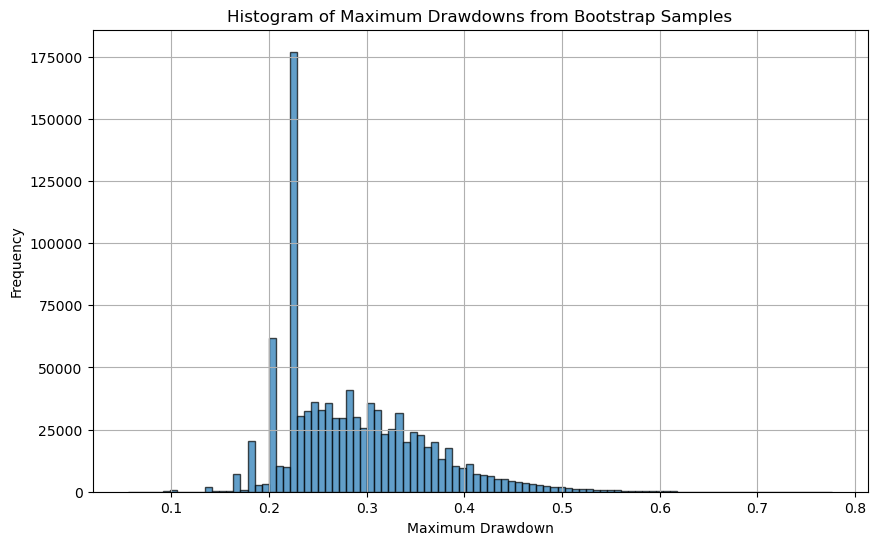

Probability of drawdown exceeding 25%: 60.4501%
Probability of drawdown exceeding 50%: 1.0030%
95th percentile max drawdown: 42.25%
99th percentile max drawdown: 50.01%
Mean max drawdown: 28.69%
Median max drawdown: 27.33%


In [63]:
qprofits = (profits_flat @ (kelly_flat * 0.252).clamp(max=1.0)) #kelly_profits * 0.18
# n_samples = 1000000

# slength = int(qprofits.size(0) / num_years * 5.0)

# # Create a set of bootstrap samples
# bootstrap_samples = torch.randint(0, qprofits.size(0), (n_samples, slength), device=qprofits.device)
bootstrap_profits = qprofits[bootstrap_samples]

bootstrap_returns = (bootstrap_profits + 1.0).cumprod(dim=1)

# Calculate max drawdown for each bootstrap sample
running_max = torch.cummax(bootstrap_returns, dim=1).values
drawdowns = (bootstrap_returns - running_max) / running_max * -1.0
max_drawdowns, _ = drawdowns.max(dim=1)

# Plot a histogram of the max drawdowns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns.cpu().numpy(), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Drawdowns from Bootstrap Samples')
plt.grid(True)
plt.show()

# Probability of drawdown exceeding 50%
prob_exceed_50 = (max_drawdowns > 0.5).float().mean().item()
# Probability of drawdown exceeding 25%
prob_exceed_25 = (max_drawdowns > 0.25).float().mean().item()
print(f"Probability of drawdown exceeding 25%: {prob_exceed_25 * 100:.4f}%")
print(f"Probability of drawdown exceeding 50%: {prob_exceed_50 * 100:.4f}%")
print(f"95th percentile max drawdown: {torch.quantile(max_drawdowns, 0.95).item() * 100:.2f}%")
print(f"99th percentile max drawdown: {torch.quantile(max_drawdowns, 0.99).item() * 100:.2f}%")
print(f"Mean max drawdown: {max_drawdowns.mean().item() * 100:.2f}%")
print(f"Median max drawdown: {torch.median(max_drawdowns).item() * 100:.2f}%")

In [16]:
bootstrap_profits._is_view()

False

In [ ]:
trade_grid = """
<bd class="dim-scroller"><row data-key="p1762062476073700000051167"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 21, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:51am → 3:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,850</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$730</span></div></bd></row><row data-key="p1762062476073700000051168"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 24, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:32pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,987</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$6</span></div></bd></row><row data-key="p1762062476073700000051169"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 26, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:03pm → 3:09pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,675</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,510</span></div></bd></row><row data-key="p1762062476073700000051170"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 28, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:00am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$265</span></div></bd></row><row data-key="p1762062476073700000051171"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 31, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:51am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,920</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$80</span></div></bd></row><row data-key="p1762062476073700000051172"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:48pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,830</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$170</span></div></bd></row><row data-key="p1762062476073700000051173"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 4, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:01pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p1762062476073700000051174"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 7, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,673</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$445</span></div></bd></row><row data-key="p1762062476073700000051175"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 9, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$197</span></div></bd></row><row data-key="p1762062476073700000051176"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 14, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:32pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,772</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$166</span></div></bd></row><row data-key="p1762062476073700000051177"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 16, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:22pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,882</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$118</span></div></bd></row><row data-key="p1762062476073700000051178"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 22, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 2:11pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,715</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,310</span></div></bd></row><row data-key="p1762062476073700000051179"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:43am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,730</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$270</span></div></bd></row><row data-key="p1762062476073700000051180"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 28, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,560</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$400</span></div></bd></row><row data-key="p1762062476073700000051181"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,565</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$435</span></div></bd></row><row data-key="p1762062476073700000051182"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 9, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,720</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$280</span></div></bd></row><row data-key="p1762062476073700000051183"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 14, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:52am → 1:34pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,805</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$940</span></div></bd></row><row data-key="p1762062476073700000051184"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 18, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,849</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$151</span></div></bd></row><row data-key="p1762062476073700000051185"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 23, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,710</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$207</span></div></bd></row><row data-key="p1762062476073700000051186"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,745</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$198</span></div></bd></row><row data-key="p1762062476073700000051187"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 28, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:45pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,935</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$65</span></div></bd></row><row data-key="p1762062476073700000051188"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 31, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,663</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,453</span></div></bd></row><row data-key="p1762062476073700000051189"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 4, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$157</span></div></bd></row><row data-key="p1762062476073700000051190"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 6, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:03pm → 2:13pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,913</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$450</span></div></bd></row><row data-key="p1762062476073700000051191"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 8, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:52am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,765</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$225</span></div></bd></row><row data-key="p1762062476073700000051192"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 13, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:04am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,792</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$208</span></div></bd></row><row data-key="p1762062476073700000051193"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 18, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:56pm → 3:31pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,907</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$449</span></div></bd></row><row data-key="p1762062476073700000051194"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$265</span></div></bd></row><row data-key="p1762062476073700000051195"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 27, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:28pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$5</span></div></bd></row><row data-key="p1762062476073700000051196"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 1:47pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,003</span></div></bd></row><row data-key="p1762062476073700000051197"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 3, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,715</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$268</span></div></bd></row><row data-key="p1762062476073700000051198"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 4, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:40pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,495</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$505</span></div></bd></row><row data-key="p1762062476073700000051199"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 6, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:47am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,710</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$290</span></div></bd></row><row data-key="p1762062476073700000051200"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 11, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 1:47pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,780</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,045</span></div></bd></row><row data-key="p1762062476073700000051201"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 13, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:28am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,870</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$130</span></div></bd></row><row data-key="p1762062476073700000051202"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 16, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:03pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,800</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$190</span></div></bd></row><row data-key="p1762062476073700000051203"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 17, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:44pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,705</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$295</span></div></bd></row><row data-key="p1762062476073700000051204"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 23, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,720</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$280</span></div></bd></row><row data-key="p1762062476073700000051205"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,700</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$300</span></div></bd></row><row data-key="p1762062476073700000051206"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 26, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:00am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$70</span></div></bd></row><row data-key="p1762062476073700000051207"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 27, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:43am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,960</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$40</span></div></bd></row><row data-key="p1762062476073700000051208"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 31, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:57am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$108</span></div></bd></row><row data-key="p1762062476073700000051209"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:03am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,802</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$198</span></div></bd></row><row data-key="p1762062476073700000051210"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 7, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,780</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$220</span></div></bd></row><row data-key="p1762062476073700000051211"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 21, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,905</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$95</span></div></bd></row><row data-key="p1762062476073700000051212"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 22, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$70</span></div></bd></row><row data-key="p1762062476073700000051213"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 23, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,718</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$282</span></div></bd></row><row data-key="p1762062476073700000051214"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 24, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:06am → 3:54pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,963</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$30</span></div></bd></row><row data-key="p1762062476073700000051215"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 30, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:27am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476073700000051216"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 1, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:47pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,993</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$7</span></div></bd></row><row data-key="p1762062476073700000051217"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 5, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:44pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,972</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$28</span></div></bd></row><row data-key="p1762062476073700000051218"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 6, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:34pm → 3:52pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,893</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$97</span></div></bd></row><row data-key="p1762062476073700000051219"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 7, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:53am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,857</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$143</span></div></bd></row><row data-key="p1762062476073700000051220"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 8, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,865</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p1762062476073700000051221"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 13, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$265</span></div></bd></row><row data-key="p1762062476073700000051222"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 14, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:43am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,915</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$85</span></div></bd></row><row data-key="p1762062476073700000051223"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 15, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,820</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$180</span></div></bd></row><row data-key="p1762062476073700000051224"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 19, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476073700000051225"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 20, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$212</span></div></bd></row><row data-key="p1762062476073700000051226"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 21, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$70</span></div></bd></row><row data-key="p1762062476073700000051227"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:36am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,804</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$182</span></div></bd></row><row data-key="p1762062476073700000051228"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 27, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:56am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,435</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$565</span></div></bd></row><row data-key="p1762062476073700000051229"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 28, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:24am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,945</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$55</span></div></bd></row><row data-key="p1762062476073700000051230"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 29, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:54pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,993</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$7</span></div></bd></row><row data-key="p1762062476073700000051231"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 1, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:51am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,878</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$122</span></div></bd></row><row data-key="p1762062476073700000051232"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:44am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,770</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$230</span></div></bd></row><row data-key="p1762062476073700000051233"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 3, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:13am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p1762062476073700000051234"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 10, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:01am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,815</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$185</span></div></bd></row><row data-key="p1762062476073799999951235"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 12, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:03am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,840</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$160</span></div></bd></row><row data-key="p1762062476073799999951236"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 15, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:45am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,898</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$102</span></div></bd></row><row data-key="p1762062476073799999951237"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 16, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:18am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,723</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$277</span></div></bd></row><row data-key="p1762062476073799999951238"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 17, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:03pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,768</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$192</span></div></bd></row><row data-key="p1762062476073799999951239"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 18, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:49am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,730</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$270</span></div></bd></row><row data-key="p1762062476073799999951240"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 24, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:15am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,904</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$96</span></div></bd></row><row data-key="p1762062476073799999951241"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$90</span></div></bd></row><row data-key="p1762062476073799999951242"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 29, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:49pm → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,873</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p1762062476073799999951243"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 1, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:23pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,952</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$48</span></div></bd></row><row data-key="p1762062476073799999951244"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 1:09pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,795</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$960</span></div></bd></row><row data-key="p1762062476073799999951245"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 6, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:09am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,890</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$100</span></div></bd></row><row data-key="p1762062476073799999951246"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 7, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,680</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$320</span></div></bd></row><row data-key="p1762062476073799999951247"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 8, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,868</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$132</span></div></bd></row><row data-key="p1762062476073799999951248"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 9, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,795</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$205</span></div></bd></row><row data-key="p1762062476073799999951249"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 14, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:55am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,777</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$136</span></div></bd></row><row data-key="p1762062476073799999951250"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 19, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,755</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$245</span></div></bd></row><row data-key="p1762062476073799999951251"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 20, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:06pm → 1:56pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,805</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$935</span></div></bd></row><row data-key="p1762062476073799999951252"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 21, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,235</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,220</span></div></bd></row><row data-key="p1762062476073799999951253"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 28, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,700</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$300</span></div></bd></row><row data-key="p1762062476073799999951254"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 30, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,723</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$335</span></div></bd></row><row data-key="p1762062476073799999951255"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 3, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,907</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$93</span></div></bd></row><row data-key="p1762062476073799999951256"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 4, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:59am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,942</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$58</span></div></bd></row><row data-key="p1762062476073799999951257"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 5, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:19pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,902</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$98</span></div></bd></row><row data-key="p1762062476073799999951258"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 11, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:04am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,833</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$157</span></div></bd></row><row data-key="p1762062476073799999951259"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 12, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:08pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,787</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$199</span></div></bd></row><row data-key="p1762062476073799999951260"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 13, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,832</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$168</span></div></bd></row><row data-key="p1762062476073799999951261"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 21, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:02pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,938</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$62</span></div></bd></row><row data-key="p1762062476073799999951262"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 24, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:43pm → 2:44pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$8</span></div></bd></row><row data-key="p1762062476073799999951263"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 25, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476073799999951264"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 26, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,844</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$144</span></div></bd></row><row data-key="p1762062476073799999951265"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 27, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,832</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$141</span></div></bd></row><row data-key="p1762062476073799999951266"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 28, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,898</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$102</span></div></bd></row><row data-key="p1762062476073799999951267"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 31, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:25am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,717</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$269</span></div></bd></row><row data-key="p1762062476073799999951268"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 3, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,847</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$153</span></div></bd></row><row data-key="p1762062476073799999951269"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 4, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 11:41am</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$475</span></div></bd></row><row data-key="p1762062476073799999951270"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 7, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:06pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,970</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$30</span></div></bd></row><row data-key="p1762062476073799999951271"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 8, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 2:27pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,838</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$748</span></div></bd></row><row data-key="p1762062476073799999951272"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 10, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:59am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,890</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$110</span></div></bd></row><row data-key="p1762062476073799999951273"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 11, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:25pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,975</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$25</span></div></bd></row><row data-key="p1762062476073799999951274"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 14, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:37pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,913</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$25</span></div></bd></row><row data-key="p1762062476073799999951275"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 17, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:56am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,785</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$215</span></div></bd></row><row data-key="p1762062476073799999951276"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 22, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,745</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$255</span></div></bd></row><row data-key="p1762062476073799999951277"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 23, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,852</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$148</span></div></bd></row><row data-key="p1762062476073799999951278"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 29, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 11:20am</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$928</span></div></bd></row><row data-key="p1762062476073799999951279"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 30, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:31pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,540</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$460</span></div></bd></row><row data-key="p1762062476073799999951280"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 2, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,765</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$235</span></div></bd></row><row data-key="p1762062476073799999951281"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 7, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:53am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,810</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476073799999951282"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 8, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,887</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$103</span></div></bd></row><row data-key="p1762062476073799999951283"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 9, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:00am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,870</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$74</span></div></bd></row><row data-key="p1762062476073799999951284"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 12, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:05am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,725</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$275</span></div></bd></row><row data-key="p1762062476073799999951285"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 14, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:45am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,345</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$875</span></div></bd></row><row data-key="p1762062476073799999951286"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 20, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,893</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$107</span></div></bd></row><row data-key="p1762062476073799999951287"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 21, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,894</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$106</span></div></bd></row><row data-key="p1762062476073899999981288"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 23, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p1762062476073899999981289"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 27, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:47am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,860</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$140</span></div></bd></row><row data-key="p1762062476073899999981290"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 29, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,920</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$80</span></div></bd></row><row data-key="p1762062476073899999981291"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 30, 2022</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:47pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,995</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$5</span></div></bd></row><row data-key="p1762062476073899999981292"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 4, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,867</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$133</span></div></bd></row><row data-key="p1762062476073899999981293"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 6, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,922</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$78</span></div></bd></row><row data-key="p1762062476073899999981294"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 9, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 3:15pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,870</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$742</span></div></bd></row><row data-key="p1762062476073899999981295"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 10, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:13pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,980</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$20</span></div></bd></row><row data-key="p1762062476073899999981296"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 11, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:11pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,757</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$243</span></div></bd></row><row data-key="p1762062476073899999981297"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 12, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,880</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$120</span></div></bd></row><row data-key="p1762062476073899999981298"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,865</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p1762062476073899999981299"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 19, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:41pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,901</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$89</span></div></bd></row><row data-key="p1762062476073899999981300"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 20, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p1762062476073899999981301"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 23, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,902</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$98</span></div></bd></row><row data-key="p1762062476073899999981302"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 24, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:55am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,839</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$161</span></div></bd></row><row data-key="p1762062476073899999981303"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 25, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:52am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,858</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$142</span></div></bd></row><row data-key="p1762062476073899999981304"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 27, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:39pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,960</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$40</span></div></bd></row><row data-key="p1762062476073899999981305"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 31, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,740</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$260</span></div></bd></row><row data-key="p1762062476073899999981306"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 1, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:40pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,585</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$415</span></div></bd></row><row data-key="p1762062476073899999981307"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 2, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,792</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$194</span></div></bd></row><row data-key="p1762062476073899999981308"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 3, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$102</span></div></bd></row><row data-key="p1762062476073899999981309"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 6, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:25am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,802</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$181</span></div></bd></row><row data-key="p1762062476073899999981310"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 7, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:09am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,400</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$600</span></div></bd></row><row data-key="p1762062476073899999981311"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 10, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:21pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,892</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$108</span></div></bd></row><row data-key="p1762062476073899999981312"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,832</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$168</span></div></bd></row><row data-key="p1762062476073899999981313"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 15, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,752</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$248</span></div></bd></row><row data-key="p1762062476073899999981314"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 16, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,728</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$177</span></div></bd></row><row data-key="p1762062476073899999981315"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 17, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$265</span></div></bd></row><row data-key="p1762062476073899999981316"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 22, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:43pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,737</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$177</span></div></bd></row><row data-key="p1762062476073899999981317"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 24, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:58pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,985</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$8</span></div></bd></row><row data-key="p1762062476073899999981318"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:17am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,727</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$116</span></div></bd></row><row data-key="p1762062476073899999981319"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 2, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,730</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$270</span></div></bd></row><row data-key="p1762062476073899999981320"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 3, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,760</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$240</span></div></bd></row><row data-key="p1762062476073899999981321"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 6, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:44am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,858</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$22</span></div></bd></row><row data-key="p1762062476073899999981322"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 8, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,745</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$255</span></div></bd></row><row data-key="p1762062476073899999981323"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 10, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:00am → 1:28pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$943</span></div></bd></row><row data-key="p1762062476073899999981324"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:57am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,857</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$143</span></div></bd></row><row data-key="p1762062476073899999981325"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 14, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,780</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$171</span></div></bd></row><row data-key="p1762062476073899999981326"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 15, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:25pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,808</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$175</span></div></bd></row><row data-key="p1762062476073899999981327"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 16, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:42am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,740</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$260</span></div></bd></row><row data-key="p1762062476073899999981328"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 20, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,665</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$335</span></div></bd></row><row data-key="p1762062476073899999981329"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:13pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,985</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$15</span></div></bd></row><row data-key="p1762062476073899999981330"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 22, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,290</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$935</span></div></bd></row><row data-key="p1762062476073899999981331"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 23, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 2:30pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,822</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$822</span></div></bd></row><row data-key="p1762062476073899999981332"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 24, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,685</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$315</span></div></bd></row><row data-key="p1762062476073899999981333"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 29, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:11pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,922</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$78</span></div></bd></row><row data-key="p1762062476073899999981334"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 31, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,837</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$163</span></div></bd></row><row data-key="p1762062476073899999981335"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 3, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,882</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$118</span></div></bd></row><row data-key="p1762062476073899999981336"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 6, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:22am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,878</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$122</span></div></bd></row><row data-key="p1762062476073899999981337"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 10, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,728</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$272</span></div></bd></row><row data-key="p17620624760731338"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 11, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:12pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,814</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$94</span></div></bd></row><row data-key="p17620624760731339"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,833</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$167</span></div></bd></row><row data-key="p17620624760731340"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 17, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:17pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,975</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$25</span></div></bd></row><row data-key="p17620624760731341"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 19, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,708</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$292</span></div></bd></row><row data-key="p17620624760731342"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 20, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$62</span></div></bd></row><row data-key="p17620624760731343"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:01pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,964</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$26</span></div></bd></row><row data-key="p17620624760731344"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 24, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,730</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$258</span></div></bd></row><row data-key="p17620624760731345"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 26, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:02pm → 1:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$250</span></div></bd></row><row data-key="p17620624760731346"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 27, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$157</span></div></bd></row><row data-key="p17620624760731347"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:59am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,952</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$48</span></div></bd></row><row data-key="p17620624760731348"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 1, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:47am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,815</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$155</span></div></bd></row><row data-key="p17620624760731349"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 5, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,953</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$47</span></div></bd></row><row data-key="p17620624760731350"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 8, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:49pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,985</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$15</span></div></bd></row><row data-key="p17620624760731351"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 9, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:56pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,958</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$35</span></div></bd></row><row data-key="p17620624760731352"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 11, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:44pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,990</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$10</span></div></bd></row><row data-key="p17620624760731353"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 15, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:46pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,960</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$40</span></div></bd></row><row data-key="p17620624760731354"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 17, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:18am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,928</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$72</span></div></bd></row><row data-key="p17620624760731355"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 18, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,894</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$106</span></div></bd></row><row data-key="p17620624760731356"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 19, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,672</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$524</span></div></bd></row><row data-key="p17620624760731357"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 23, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:46am → 1:31pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,852</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$777</span></div></bd></row><row data-key="p17620624760731358"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 25, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:01pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,980</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$20</span></div></bd></row><row data-key="p17620624760731359"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 26, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,929</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$71</span></div></bd></row><row data-key="p17620624760731360"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 1, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:42am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,898</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$102</span></div></bd></row><row data-key="p17620624760731361"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 2, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:47am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$90</span></div></bd></row><row data-key="p17620624760731362"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 5, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:15pm → 2:33pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,942</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$282</span></div></bd></row><row data-key="p17620624760731363"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 6, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,845</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$155</span></div></bd></row><row data-key="p17620624760731364"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 8, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p17620624760731365"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 9, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 11:32am</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,887</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$587</span></div></bd></row><row data-key="p17620624760731366"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 12, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,747</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$253</span></div></bd></row><row data-key="p17620624760731367"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:24am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,947</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$53</span></div></bd></row><row data-key="p17620624760731368"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 14, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,575</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$113</span></div></bd></row><row data-key="p17620624760731369"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 15, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:49am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,970</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$30</span></div></bd></row><row data-key="p17620624760731370"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 20, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:22pm → 1:23pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$9</span></div></bd></row><row data-key="p17620624760731371"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:20pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,990</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val zero pnl">--</span></div></bd></row><row data-key="p17620624760731372"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 22, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:31pm → 2:32pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$9</span></div></bd></row><row data-key="p17620624760731373"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 23, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,880</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$110</span></div></bd></row><row data-key="p17620624760731374"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 27, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$157</span></div></bd></row><row data-key="p17620624760731375"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,808</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$178</span></div></bd></row><row data-key="p17620624760731376"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 29, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:18am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p17620624760731377"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 30, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:54pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,968</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$22</span></div></bd></row><row data-key="p17620624760731378"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 5, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p17620624760731379"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 7, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:38am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$5</span></div></bd></row><row data-key="p17620624760731380"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 11, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:53am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,947</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$53</span></div></bd></row><row data-key="p17620624760731381"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 12, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 11:57am</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$477</span></div></bd></row><row data-key="p17620624760731382"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:03pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p17620624760731383"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 17, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:50am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,852</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$148</span></div></bd></row><row data-key="p17620624760731384"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 18, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,960</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$40</span></div></bd></row><row data-key="p17620624760731385"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 19, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:04pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,903</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$67</span></div></bd></row><row data-key="p17620624760731386"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:41pm → 3:10pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,974</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$224</span></div></bd></row><row data-key="p17620624760731387"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 24, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:16am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,907</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$86</span></div></bd></row><row data-key="p17620624760731388"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 25, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,907</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$93</span></div></bd></row><row data-key="p17620624760731389"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 26, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:37pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,555</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$400</span></div></bd></row><row data-key="p17620624760731390"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:12am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$95</span></div></bd></row><row data-key="p17620624760731391"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 3, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:19am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,863</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$137</span></div></bd></row><row data-key="p17620624760731392"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 4, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:46am → 2:04pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$210</span></div></bd></row><row data-key="p17620624760731393"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 7, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,838</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$162</span></div></bd></row><row data-key="p17620624760731394"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 8, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:26pm → 3:27pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$10</span></div></bd></row><row data-key="p17620624760731395"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 11, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p17620624760731396"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 14, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,862</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$138</span></div></bd></row><row data-key="p17620624760731397"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 18, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:01am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,833</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$167</span></div></bd></row><row data-key="p17620624760731398"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:44pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,994</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$6</span></div></bd></row><row data-key="p17620624760731399"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 23, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:43am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,847</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$153</span></div></bd></row><row data-key="p17620624760731400"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 25, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:01pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,985</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$8</span></div></bd></row><row data-key="p17620624760731401"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:48pm → 3:49pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$14</span></div></bd></row><row data-key="p17620624760731402"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 29, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,952</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$48</span></div></bd></row><row data-key="p17620624760731403"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 30, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:47pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,979</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$21</span></div></bd></row><row data-key="p17620624760731404"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 31, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,768</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p17620624760731405"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 5, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:07am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,868</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$118</span></div></bd></row><row data-key="p17620624760731406"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 7, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:43am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$212</span></div></bd></row><row data-key="p17620624760731407"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 8, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,904</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$44</span></div></bd></row><row data-key="p17620624760731408"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 12, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:21pm → 2:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,952</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$399</span></div></bd></row><row data-key="p17620624760731409"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:58am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,915</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$85</span></div></bd></row><row data-key="p17620624760731410"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 14, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,899</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$101</span></div></bd></row><row data-key="p17620624760731411"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 18, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,762</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$238</span></div></bd></row><row data-key="p17620624760731412"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 22, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,792</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$567</span></div></bd></row><row data-key="p17620624760731413"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 25, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:17am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,832</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$168</span></div></bd></row><row data-key="p17620624760731414"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,802</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$198</span></div></bd></row><row data-key="p17620624760731415"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 2, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:22am → 12:10pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$760</span></div></bd></row><row data-key="p17620624760731416"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 4, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,877</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$123</span></div></bd></row><row data-key="p17620624760731417"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 5, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:41pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,974</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$16</span></div></bd></row><row data-key="p17620624760731418"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 6, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,812</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$188</span></div></bd></row><row data-key="p17620624760731419"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 9, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:08pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p17620624760731420"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 10, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,865</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p17620624760731421"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 12, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:22pm → 1:06pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,915</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$415</span></div></bd></row><row data-key="p17620624760731422"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 16, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,888</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$112</span></div></bd></row><row data-key="p17620624760731423"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 17, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,868</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$132</span></div></bd></row><row data-key="p17620624760731424"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 19, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:03pm → 2:37pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,800</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$920</span></div></bd></row><row data-key="p17620624760731425"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 23, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:06am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,892</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$108</span></div></bd></row><row data-key="p17620624760731426"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 24, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,675</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$318</span></div></bd></row><row data-key="p17620624760731427"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 27, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:17am → 2:06pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,220</span></div></bd></row><row data-key="p17620624760731428"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 30, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:31pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,937</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$63</span></div></bd></row><row data-key="p17620624760731429"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 31, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:53am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,810</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$190</span></div></bd></row><row data-key="p17620624760731430"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 1, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,685</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$315</span></div></bd></row><row data-key="p17620624760731431"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 2, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,894</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$106</span></div></bd></row><row data-key="p17620624760731432"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 3, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:18pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,975</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$25</span></div></bd></row><row data-key="p17620624760731433"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 7, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p17620624760731434"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 10, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:06am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,860</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$140</span></div></bd></row><row data-key="p17620624760731435"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,828</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$172</span></div></bd></row><row data-key="p17620624760731436"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 14, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$45</span></div></bd></row><row data-key="p17620624760731437"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 15, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:51am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,867</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$1</span></div></bd></row><row data-key="p17620624760731438"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 17, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:15pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,945</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$36</span></div></bd></row><row data-key="p17620624760731439"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 20, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$70</span></div></bd></row><row data-key="p17620624760731440"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:40pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,905</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$95</span></div></bd></row><row data-key="p17620624760731441"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 27, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:57am → 3:55pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,935</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$58</span></div></bd></row><row data-key="p17620624760731442"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$190</span></div></bd></row><row data-key="p17620624760731443"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 1, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:12am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p17620624760731444"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 5, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,922</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$78</span></div></bd></row><row data-key="p17620624760731445"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 7, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,865</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p17620624760731446"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 11, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$90</span></div></bd></row><row data-key="p17620624760731447"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 12, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$105</span></div></bd></row><row data-key="p17620624760731448"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 13, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,522</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$478</span></div></bd></row><row data-key="p17620624760731449"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 15, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,823</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$155</span></div></bd></row><row data-key="p17620624760731450"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 18, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:18am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,903</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$97</span></div></bd></row><row data-key="p17620624760731451"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 19, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$60</span></div></bd></row><row data-key="p17620624760731452"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 20, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 2:43pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,900</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$478</span></div></bd></row><row data-key="p17620624760731453"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 21, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:47pm → 3:48pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$10</span></div></bd></row><row data-key="p17620624760731454"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 26, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p17620624760731455"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 27, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:07pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,905</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$23</span></div></bd></row><row data-key="p17620624760731456"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 28, 2023</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,737</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$191</span></div></bd></row><row data-key="p17620624760731457"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:46am → 3:04pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,900</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$472</span></div></bd></row><row data-key="p17620624760731458"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 3, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:28pm → 3:09pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,965</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$165</span></div></bd></row><row data-key="p17620624760731459"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:50am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,925</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$117</span></div></bd></row><row data-key="p17620624760731460"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,903</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$97</span></div></bd></row><row data-key="p17620624760731461"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:17am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,888</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$112</span></div></bd></row><row data-key="p17620624760731462"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:57pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$95</span></div></bd></row><row data-key="p17620624760731463"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 2:20pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$493</span></div></bd></row><row data-key="p17620624760731464"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 17, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,688</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$275</span></div></bd></row><row data-key="p17620624760731465"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,770</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$230</span></div></bd></row><row data-key="p17620624760731466"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 19, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:56am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,747</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$253</span></div></bd></row><row data-key="p17620624760731467"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 23, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:47pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,938</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$52</span></div></bd></row><row data-key="p17620624760731468"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 24, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 3:20pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,845</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$747</span></div></bd></row><row data-key="p17620624760731469"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 26, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,732</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$184</span></div></bd></row><row data-key="p17620624760731470"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 29, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:25pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,854</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$146</span></div></bd></row><row data-key="p17620624760731471"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 30, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:49am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,863</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$127</span></div></bd></row><row data-key="p17620624760731472"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 1, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$212</span></div></bd></row><row data-key="p17620624760731473"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,828</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$172</span></div></bd></row><row data-key="p17620624760731474"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 7, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p17620624760731475"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:03pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,945</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$23</span></div></bd></row><row data-key="p17620624760731476"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,747</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$243</span></div></bd></row><row data-key="p17620624760731477"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,760</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$188</span></div></bd></row><row data-key="p17620624760731478"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 13, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:10am → 2:13pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$775</span></div></bd></row><row data-key="p17620624760731479"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 14, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:27pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,990</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$10</span></div></bd></row><row data-key="p17620624760731480"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 15, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:46pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,837</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$163</span></div></bd></row><row data-key="p17620624760731481"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$78</span></div></bd></row><row data-key="p17620624760731482"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 21, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:13am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$198</span></div></bd></row><row data-key="p17620624760731483"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,867</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$133</span></div></bd></row><row data-key="p17620624760731484"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 27, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:12pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,995</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$5</span></div></bd></row><row data-key="p17620624760731485"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 28, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,810</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$180</span></div></bd></row><row data-key="p17620624760731486"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 29, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:49pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$10</span></div></bd></row><row data-key="p17620624760731487"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 1, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,820</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$180</span></div></bd></row><row data-key="p17620624760731488"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,762</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$189</span></div></bd></row><row data-key="p17620624760731489"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 6, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:03am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,898</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$88</span></div></bd></row><row data-key="p17620624760731490"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 7, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,805</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$195</span></div></bd></row><row data-key="p17620624760731491"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 11, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:36pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,870</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$130</span></div></bd></row><row data-key="p17620624760731492"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$60</span></div></bd></row><row data-key="p17620624760731493"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 13, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:09pm → 3:29pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,915</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$570</span></div></bd></row><row data-key="p17620624760731494"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 15, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,782</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$193</span></div></bd></row><row data-key="p17620624760731495"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 19, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,697</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$303</span></div></bd></row><row data-key="p17620624760731496"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 20, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,410</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$590</span></div></bd></row><row data-key="p17620624760731497"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 21, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:28pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,868</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$80</span></div></bd></row><row data-key="p17620624760731498"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:54pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$46</span></div></bd></row><row data-key="p17620624760731499"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 25, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:41pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,980</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$6</span></div></bd></row><row data-key="p17620624760731500"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 27, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:40pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,998</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$8</span></div></bd></row><row data-key="p17620624760731501"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 28, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,772</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$186</span></div></bd></row><row data-key="p17620624760731502"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:09pm → 3:10pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$9</span></div></bd></row><row data-key="p17620624760731503"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 3, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$60</span></div></bd></row><row data-key="p17620624760731504"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:10pm → 2:01pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,890</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$560</span></div></bd></row><row data-key="p17620624760731505"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 5, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,763</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$237</span></div></bd></row><row data-key="p17620624760731506"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,845</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$141</span></div></bd></row><row data-key="p17620624760731507"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,703</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$277</span></div></bd></row><row data-key="p17620624760731508"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 11, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:05pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,943</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$57</span></div></bd></row><row data-key="p17620624760731509"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:55am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,645</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$335</span></div></bd></row><row data-key="p17620624760731510"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,737</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$176</span></div></bd></row><row data-key="p17620624760731511"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:18pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,820</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$180</span></div></bd></row><row data-key="p17620624760731512"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 23, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,872</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$128</span></div></bd></row><row data-key="p17620624760731513"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 25, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:05pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,867</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$133</span></div></bd></row><row data-key="p17620624760731514"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 26, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:02am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,884</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$116</span></div></bd></row><row data-key="p17620624760731515"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 1, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:01pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,420</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$566</span></div></bd></row><row data-key="p17620624760731516"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:32pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,970</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$30</span></div></bd></row><row data-key="p17620624760731517"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 6, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,849</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$151</span></div></bd></row><row data-key="p17620624760731518"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 7, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:56am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,805</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$163</span></div></bd></row><row data-key="p17620624760731519"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:42am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,863</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$137</span></div></bd></row><row data-key="p17620624760731520"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,837</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$163</span></div></bd></row><row data-key="p17620624760731521"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 14, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:33pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,970</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$30</span></div></bd></row><row data-key="p17620624760731522"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 15, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,847</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$153</span></div></bd></row><row data-key="p17620624760731523"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:43am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,839</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$261</span></div></bd></row><row data-key="p17620624760731524"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 20, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:43am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,935</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$28</span></div></bd></row><row data-key="p17620624760731525"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 21, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$105</span></div></bd></row><row data-key="p17620624760731526"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:07am → 2:03pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,818</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,063</span></div></bd></row><row data-key="p17620624760731527"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 24, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:55am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,875</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p17620624760731528"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 29, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,797</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$189</span></div></bd></row><row data-key="p17620624760731529"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 30, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:43pm → 3:25pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$438</span></div></bd></row><row data-key="p17620624760731530"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:16pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,942</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$48</span></div></bd></row><row data-key="p17620624760731531"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 5, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,783</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$217</span></div></bd></row><row data-key="p17620624760731532"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 7, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$178</span></div></bd></row><row data-key="p17620624760731533"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,748</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$252</span></div></bd></row><row data-key="p17620624760731534"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 11, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:00am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,920</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$80</span></div></bd></row><row data-key="p17620624760731535"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,750</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$167</span></div></bd></row><row data-key="p17620624760731536"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 14, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:53pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$80</span></div></bd></row><row data-key="p17620624760731537"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 17, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:58am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,804</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$196</span></div></bd></row><row data-key="p17620624760731538"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:39pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,934</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$52</span></div></bd></row><row data-key="p17620624760731539"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 21, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:02am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p17620624760731540"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 25, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,742</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$248</span></div></bd></row><row data-key="p17620624760731541"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 26, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:51am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,860</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$140</span></div></bd></row><row data-key="p17620624760731542"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,823</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$177</span></div></bd></row><row data-key="p17620624760731543"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 5, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:50am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,814</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$186</span></div></bd></row><row data-key="p17620624760731544"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:04pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,905</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$36</span></div></bd></row><row data-key="p17620624760731545"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,828</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$172</span></div></bd></row><row data-key="p17620624760731546"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,879</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$107</span></div></bd></row><row data-key="p17620624760731547"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 15, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,738</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$425</span></div></bd></row><row data-key="p1762062476073100000021548"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:52am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,795</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$195</span></div></bd></row><row data-key="p1762062476073100000021549"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:07am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,857</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$143</span></div></bd></row><row data-key="p1762062476073100000021550"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 23, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:16am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$38</span></div></bd></row><row data-key="p1762062476073100000021551"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 25, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$155</span></div></bd></row><row data-key="p1762062476073100000021552"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 26, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:59am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,822</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$164</span></div></bd></row><row data-key="p1762062476073100000021553"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 31, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,590</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$388</span></div></bd></row><row data-key="p1762062476073100000021554"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 5, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:25am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,918</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$69</span></div></bd></row><row data-key="p1762062476073100000021555"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 6, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,825</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$175</span></div></bd></row><row data-key="p1762062476073100000021556"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,815</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$185</span></div></bd></row><row data-key="p1762062476073100000021557"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:56am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,645</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$355</span></div></bd></row><row data-key="p1762062476073100000021558"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,847</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$106</span></div></bd></row><row data-key="p1762062476073100000021559"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 13, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:51am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,710</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$290</span></div></bd></row><row data-key="p1762062476073100000021560"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 14, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,827</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$173</span></div></bd></row><row data-key="p1762062476073100000021561"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 15, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$265</span></div></bd></row><row data-key="p1762062476073100000021562"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:11pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,869</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$121</span></div></bd></row><row data-key="p1762062476073100000021563"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 19, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,780</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$220</span></div></bd></row><row data-key="p1762062476073100000021564"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 21, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,777</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$204</span></div></bd></row><row data-key="p1762062476073100000021565"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 27, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$105</span></div></bd></row><row data-key="p1762062476073100000021566"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 29, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,807</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$622</span></div></bd></row><row data-key="p1762062476073100000021567"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 30, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:51pm → 3:52pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,995</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$5</span></div></bd></row><row data-key="p1762062476073100000021568"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,758</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$195</span></div></bd></row><row data-key="p1762062476073100000021569"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:04pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,825</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476073100000021570"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:33pm → 3:40pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,998</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$17</span></div></bd></row><row data-key="p1762062476073100000021571"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 11, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:12pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,987</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$13</span></div></bd></row><row data-key="p1762062476073100000021572"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,760</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$240</span></div></bd></row><row data-key="p1762062476073100000021573"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 13, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:45am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,820</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$170</span></div></bd></row><row data-key="p1762062476073100000021574"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 17, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:46am → 12:48pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,008</span></div></bd></row><row data-key="p1762062476073100000021575"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:31pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,365</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$120</span></div></bd></row><row data-key="p1762062476073100000021576"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 19, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,807</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$178</span></div></bd></row><row data-key="p1762062476073100000021577"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 20, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:39pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,993</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$8</span></div></bd></row><row data-key="p1762062476073100000021578"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 24, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:54am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$60</span></div></bd></row><row data-key="p1762062476073100000021579"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 30, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:05am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,740</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$220</span></div></bd></row><row data-key="p1762062476073100000021580"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,827</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$173</span></div></bd></row><row data-key="p1762062476073100000021581"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:35pm → 3:36pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$10</span></div></bd></row><row data-key="p1762062476073100000021582"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:43am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p1762062476073100000021583"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 9, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:42am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,760</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$240</span></div></bd></row><row data-key="p1762062476073100000021584"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:56am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$135</span></div></bd></row><row data-key="p1762062476073100000021585"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 11, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:10pm → 3:11pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$2,000</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$10</span></div></bd></row><row data-key="p1762062476073100000021586"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 14, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,918</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$82</span></div></bd></row><row data-key="p1762062476073100000021587"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:55pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,935</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$65</span></div></bd></row><row data-key="p1762062476073100000021588"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:43pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,932</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$68</span></div></bd></row><row data-key="p1762062476073100000021589"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:04am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,820</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$180</span></div></bd></row><row data-key="p1762062476073100000021590"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 23, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 12:28pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,803</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$903</span></div></bd></row><row data-key="p1762062476073100000021591"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 28, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,672</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$233</span></div></bd></row><row data-key="p1762062476073100000021592"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 29, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:01pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,973</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$27</span></div></bd></row><row data-key="p1762062476073100000021593"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 30, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:32am → 1:41pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,965</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$178</span></div></bd></row><row data-key="p1762062476073100000021594"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 1, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$22</span></div></bd></row><row data-key="p1762062476073100000021595"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 5, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,875</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$125</span></div></bd></row><row data-key="p1762062476073100000021596"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 6, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,880</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$120</span></div></bd></row><row data-key="p1762062476073100000021597"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 7, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,570</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$430</span></div></bd></row><row data-key="p1762062476073100000021598"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 8, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,825</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476073100000021599"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 13, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:28am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,938</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$62</span></div></bd></row><row data-key="p1762062476073100000021600"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,840</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$160</span></div></bd></row><row data-key="p1762062476073100000021601"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 19, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,692</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$308</span></div></bd></row><row data-key="p1762062476073100000021602"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 21, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:44pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,979</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$21</span></div></bd></row><row data-key="p1762062476073100000021603"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 22, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:12pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,944</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$56</span></div></bd></row><row data-key="p1762062476073100000021604"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Nov 26, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,875</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$125</span></div></bd></row><row data-key="p1762062476073100000021605"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 2, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:42am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,870</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$130</span></div></bd></row><row data-key="p1762062476073100000021606"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 3, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:48pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,995</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$5</span></div></bd></row><row data-key="p1762062476073100000021607"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 4, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$212</span></div></bd></row><row data-key="p1762062476073100000021608"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 5, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:47pm → 1:24pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,940</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$325</span></div></bd></row><row data-key="p1762062476073100000021609"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 10, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 3:06pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,863</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$650</span></div></bd></row><row data-key="p1762062476073100000021610"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 11, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:27am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$45</span></div></bd></row><row data-key="p1762062476073100000021611"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 12, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,914</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$29</span></div></bd></row><row data-key="p1762062476073100000021612"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 16, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,912</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$88</span></div></bd></row><row data-key="p1762062476073100000021613"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 17, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:10am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,925</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$56</span></div></bd></row><row data-key="p1762062476073100000021614"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 18, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:52pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,608</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,613</span></div></bd></row><row data-key="p1762062476073200000051615"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 20, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,924</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$76</span></div></bd></row><row data-key="p1762062476074200000051616"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 23, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:47am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,929</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$71</span></div></bd></row><row data-key="p1762062476074200000051617"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 26, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,812</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$188</span></div></bd></row><row data-key="p1762062476074200000051618"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Dec 30, 2024</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:02pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$45</span></div></bd></row><row data-key="p1762062476074200000051619"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 3, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:04am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,828</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$172</span></div></bd></row><row data-key="p1762062476074200000051620"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 6, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:54am → 1:46pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,919</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$442</span></div></bd></row><row data-key="p1762062476074200000051621"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 8, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,780</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$220</span></div></bd></row><row data-key="p1762062476074200000051622"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 13, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:45am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,775</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$225</span></div></bd></row><row data-key="p1762062476074200000051623"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 15, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:29pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,990</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$10</span></div></bd></row><row data-key="p1762062476074200000051624"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 16, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:09am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,840</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$150</span></div></bd></row><row data-key="p1762062476074200000051625"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 17, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:54am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,798</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$202</span></div></bd></row><row data-key="p1762062476074200000051626"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 21, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:29pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,958</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$42</span></div></bd></row><row data-key="p1762062476074200000051627"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 22, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,783</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$207</span></div></bd></row><row data-key="p1762062476074200000051628"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 23, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,797</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$203</span></div></bd></row><row data-key="p1762062476074200000051629"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 27, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,908</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$82</span></div></bd></row><row data-key="p1762062476074200000051630"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 28, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:58am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,960</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$40</span></div></bd></row><row data-key="p1762062476074200000051631"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 30, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:03pm → 3:39pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,995</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$30</span></div></bd></row><row data-key="p1762062476074200000051632"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jan 31, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 2:07pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,752</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,182</span></div></bd></row><row data-key="p1762062476074200000051633"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 3, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p1762062476074200000051634"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 4, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,853</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$147</span></div></bd></row><row data-key="p1762062476074200000051635"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 5, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:10am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476074200000051636"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 10, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:52pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,840</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$153</span></div></bd></row><row data-key="p1762062476074200000051637"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,755</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$245</span></div></bd></row><row data-key="p1762062476074200000051638"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 12, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p1762062476074200000051639"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 13, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,848</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$152</span></div></bd></row><row data-key="p1762062476074200000051640"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 19, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,668</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$332</span></div></bd></row><row data-key="p1762062476074200000051641"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 26, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:02am → 12:57pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,925</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$375</span></div></bd></row><row data-key="p1762062476074200000051642"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Feb 28, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$157</span></div></bd></row><row data-key="p1762062476074200000051643"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 4, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:56pm → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,970</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$15</span></div></bd></row><row data-key="p1762062476074200000051644"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 5, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:52pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,745</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$255</span></div></bd></row><row data-key="p1762062476074200000051645"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 6, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,680</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$500</span></div></bd></row><row data-key="p1762062476074200000051646"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 7, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:03pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,873</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$127</span></div></bd></row><row data-key="p1762062476074200000051647"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:53pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,953</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$37</span></div></bd></row><row data-key="p1762062476074200000051648"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 14, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:00am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,795</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$205</span></div></bd></row><row data-key="p1762062476074200000051649"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 17, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:37pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,950</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$50</span></div></bd></row><row data-key="p1762062476074200000051650"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 19, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:50am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,690</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$310</span></div></bd></row><row data-key="p1762062476074200000051651"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 20, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,928</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$72</span></div></bd></row><row data-key="p1762062476074200000051652"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 21, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:57am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,680</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$320</span></div></bd></row><row data-key="p1762062476074200000051653"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 24, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:49am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,905</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$95</span></div></bd></row><row data-key="p1762062476074200000051654"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 25, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,773</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$215</span></div></bd></row><row data-key="p1762062476074200000051655"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 27, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,840</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$160</span></div></bd></row><row data-key="p1762062476074200000051656"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Mar 31, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,795</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$205</span></div></bd></row><row data-key="p1762062476074200000051657"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 1, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:52am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,828</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$172</span></div></bd></row><row data-key="p1762062476074200000051658"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 2, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,813</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$187</span></div></bd></row><row data-key="p1762062476074200000051659"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 9, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:03pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,755</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$245</span></div></bd></row><row data-key="p1762062476074200000051660"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:32pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,775</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$225</span></div></bd></row><row data-key="p1762062476074200000051661"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 16, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:25am → 1:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,735</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,205</span></div></bd></row><row data-key="p1762062476074200000051662"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 17, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:20pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,730</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$200</span></div></bd></row><row data-key="p1762062476074200000051663"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 22, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,770</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$223</span></div></bd></row><row data-key="p1762062476074200000051664"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 24, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,800</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$200</span></div></bd></row><row data-key="p1762062476074200000051665"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 25, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:24pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,875</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$125</span></div></bd></row><row data-key="p1762062476074200000051666"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 29, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:56am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,793</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$207</span></div></bd></row><row data-key="p1762062476074200000051667"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Apr 30, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:08am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,835</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476074200000051668"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 1, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:38am → 3:51pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,705</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$278</span></div></bd></row><row data-key="p1762062476074200000051669"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 2, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:59am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,868</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$112</span></div></bd></row><row data-key="p1762062476074200000051670"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 5, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,755</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$230</span></div></bd></row><row data-key="p1762062476074200000051671"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 6, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,795</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$205</span></div></bd></row><row data-key="p1762062476074200000051672"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 7, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,560</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$245</span></div></bd></row><row data-key="p1762062476074200000051673"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 8, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:24am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,710</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$283</span></div></bd></row><row data-key="p1762062476074200000051674"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 12, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:05pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,925</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$65</span></div></bd></row><row data-key="p1762062476074200000051675"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 13, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:27am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,943</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$57</span></div></bd></row><row data-key="p1762062476074200000051676"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 15, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:05am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,763</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$237</span></div></bd></row><row data-key="p1762062476074200000051677"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 16, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:07pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,788</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$212</span></div></bd></row><row data-key="p1762062476074200000051678"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 19, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:41am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$45</span></div></bd></row><row data-key="p1762062476074200000051679"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 20, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,723</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$133</span></div></bd></row><row data-key="p1762062476074200000051680"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 21, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:09am → 1:21pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,843</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$848</span></div></bd></row><row data-key="p1762062476074200000051681"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 22, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:16pm → 3:56pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,863</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$127</span></div></bd></row><row data-key="p1762062476074200000051682"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 23, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:48am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,645</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$348</span></div></bd></row><row data-key="p1762062476074200000051683"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 27, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:47am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,943</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$57</span></div></bd></row><row data-key="p1762062476074200000051684"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">May 30, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,745</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$198</span></div></bd></row><row data-key="p1762062476074200000051685"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 2, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:52am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,928</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$72</span></div></bd></row><row data-key="p1762062476074200000051686"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 3, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,790</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$210</span></div></bd></row><row data-key="p1762062476074200000051687"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 5, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:18am → 12:53pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,927</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$357</span></div></bd></row><row data-key="p1762062476074200000051688"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 9, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,740</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$260</span></div></bd></row><row data-key="p1762062476074200000051689"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 10, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:44am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,753</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$237</span></div></bd></row><row data-key="p1762062476074200000051690"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:56am → 2:03pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,873</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$583</span></div></bd></row><row data-key="p1762062476074200000051691"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 12, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,860</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$140</span></div></bd></row><row data-key="p1762062476074200000051692"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 13, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:23am → 2:34pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,880</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$550</span></div></bd></row><row data-key="p1762062476074200000051693"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 16, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,945</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$55</span></div></bd></row><row data-key="p1762062476074200000051694"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 18, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,730</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$128</span></div></bd></row><row data-key="p1762062476074200000051695"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 23, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:31pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$45</span></div></bd></row><row data-key="p1762062476074200000051696"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 24, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:03am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,840</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$160</span></div></bd></row><row data-key="p1762062476074200000051697"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 26, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,850</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$150</span></div></bd></row><row data-key="p1762062476074200000051698"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 27, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:45am → 2:29pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,915</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$420</span></div></bd></row><row data-key="p1762062476074200000051699"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jun 30, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">3:06pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,780</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$205</span></div></bd></row><row data-key="p1762062476074200000051700"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 1, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:15pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,878</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$122</span></div></bd></row><row data-key="p1762062476074200000051701"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 2, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,898</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$102</span></div></bd></row><row data-key="p1762062476074200000051702"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 8, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:26pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,892</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$98</span></div></bd></row><row data-key="p1762062476074200000051703"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 10, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 3:53pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,808</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$182</span></div></bd></row><row data-key="p1762062476074200000051704"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,865</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$125</span></div></bd></row><row data-key="p1762062476074200000051705"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 14, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:03am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,885</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$115</span></div></bd></row><row data-key="p1762062476074200000051706"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 16, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:56pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,988</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$12</span></div></bd></row><row data-key="p1762062476074200000051707"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 17, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:06am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,895</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$105</span></div></bd></row><row data-key="p1762062476074200000051708"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 21, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,965</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$25</span></div></bd></row><row data-key="p1762062476074200000051709"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 22, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:41pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,995</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$5</span></div></bd></row><row data-key="p1762062476074200000051710"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 23, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:55am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,910</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$90</span></div></bd></row><row data-key="p1762062476074299999951711"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 24, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:51am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,805</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$165</span></div></bd></row><row data-key="p1762062476074299999951712"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 25, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:35am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,790</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$210</span></div></bd></row><row data-key="p1762062476074299999951713"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Jul 30, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:40pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,660</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,560</span></div></bd></row><row data-key="p1762062476074299999951714"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 4, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:50am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,935</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$65</span></div></bd></row><row data-key="p1762062476074299999951715"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 6, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:55am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,818</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$182</span></div></bd></row><row data-key="p1762062476074299999951716"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 8, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,898</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$92</span></div></bd></row><row data-key="p1762062476074299999951717"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:07pm → 2:45pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,837</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$744</span></div></bd></row><row data-key="p1762062476074299999951718"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 12, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:52am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,900</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$100</span></div></bd></row><row data-key="p1762062476074299999951719"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 14, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,853</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$147</span></div></bd></row><row data-key="p1762062476074299999951720"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 22, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:45am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,967</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$33</span></div></bd></row><row data-key="p1762062476074299999951721"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 25, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:13am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,865</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$63</span></div></bd></row><row data-key="p1762062476074299999951722"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 26, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:17pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,947</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$53</span></div></bd></row><row data-key="p1762062476074299999951723"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 27, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:34am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,922</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$78</span></div></bd></row><row data-key="p1762062476074299999951724"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Aug 28, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:29pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,960</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$40</span></div></bd></row><row data-key="p1762062476074299999951725"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 3, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:41am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,818</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$162</span></div></bd></row><row data-key="p1762062476074299999951726"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 4, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,793</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$207</span></div></bd></row><row data-key="p1762062476074299999951727"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 8, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:39am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,830</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$150</span></div></bd></row><row data-key="p1762062476074299999951728"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 9, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">1:26pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,925</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$75</span></div></bd></row><row data-key="p1762062476074299999951729"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 11, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:33am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,858</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$142</span></div></bd></row><row data-key="p1762062476074299999951730"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 12, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:55am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,830</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$120</span></div></bd></row><row data-key="p1762062476074299999951731"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 15, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:45am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$97</span></div></bd></row><row data-key="p1762062476074299999951732"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 17, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:01pm → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,420</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$400</span></div></bd></row><row data-key="p1762062476074299999951733"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 18, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$60</span></div></bd></row><row data-key="p1762062476074299999951734"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 19, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:49pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,923</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$77</span></div></bd></row><row data-key="p1762062476074299999951735"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 22, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,930</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$70</span></div></bd></row><row data-key="p1762062476074299999951736"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 25, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:43am → 1:58pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,937</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$332</span></div></bd></row><row data-key="p1762062476074299999951737"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Sep 30, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:22pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,855</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$145</span></div></bd></row><row data-key="p1762062476074299999951738"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 1, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:36am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,880</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$120</span></div></bd></row><row data-key="p1762062476074299999951739"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 3, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:32am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,810</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$63</span></div></bd></row><row data-key="p1762062476074299999951740"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 6, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:46am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,925</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$75</span></div></bd></row><row data-key="p1762062476074299999951741"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 8, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:31am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p1762062476074299999951742"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 13, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:10pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,860</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$140</span></div></bd></row><row data-key="p1762062476074299999951743"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 14, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:37am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,880</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$120</span></div></bd></row><row data-key="p1762062476074299999951744"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 16, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:42am → 2:01pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl lred">Stop Loss</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,710</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val neg pnl">-$1,320</span></div></bd></row><row data-key="p1762062476074299999951745"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 17, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">2:07pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,955</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$45</span></div></bd></row><row data-key="p1762062476074299999951746"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 20, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:40am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,890</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$110</span></div></bd></row><row data-key="p1762062476074299999951747"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 21, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">10:53am → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,818</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$182</span></div></bd></row><row data-key="p1762062476074299999951748"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 23, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">12:07pm → 4:00pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl">Expired</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$117</span></div></bd></row><row data-key="p1762062476074299999951749"><bd><div class="cell symbol" style="width:50%;flex:2;"><div class="clip"><span class="sym" style="margin-right:.6rem;">SPX</span><span>Short Put Spread</span></div></div><div class="sorted cell closeTime" style="width:50%;flex:2.5;"><div class="clip" style="font-size:1.4rem;line-height:1.4;margin-top:.2rem;">Oct 24, 2025</div><div class="clip" style="font-size:1.2rem;line-height:1.4;margin-top:.2rem;">11:21am → 3:50pm</div></div><div class="cell status" style="width:25%;flex:1;"><span class="lbl" title="Closed before expiration">Before Exp</span></div><div class="cell text-right nfont risk" style="width:25%;flex:1;"><span class="val pos">$1,883</span></div><div class="cell text-right nfont pnl" style="width:25%;flex:1;"><span class="val pos pnl">$107</span></div></bd></row></bd>
"""

import algorithms as algo
import ifera
import torch

df = ifera.parse_trade_log(trade_grid)
df['RoR'] = df['profit'] / df['risk']
df['premium'] = 2000.0 - df['risk'] # 20 wide credit spread
df['is_monday']= (df['date'].dt.weekday == 0).astype(int)
df['is_tuesday']= (df['date'].dt.weekday == 1).astype(int)
df['is_wednesday']= (df['date'].dt.weekday == 2).astype(int)
df['is_thursday']= (df['date'].dt.weekday == 3).astype(int)
df['is_friday']= (df['date'].dt.weekday == 4).astype(int)
df['open_minute'] = df['start_time'].apply(lambda t: t.hour * 60 + t.minute)


tree = algo.RegressionDecisionTree(max_depth=100, min_impurity_decrease=0.0, look_ahead=0)
X = torch.tensor(df[['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'open_minute', 'premium']].values, dtype=torch.float32, device='cuda')
y = torch.tensor(df['RoR'].values, dtype=torch.float32, device='cuda')


In [9]:
import ifera
import torch
import re

with open('data/results/option_alpha/filters/SPX-ORB-L-SMA_10.txt', 'r') as f:
    html = f.read()

dff = ifera.parse_filter_log(html)

def _moving_average(description):
    match = re.search(r'Price: \$(\-?[\d,]+\.\d+), [SE]MA: \$(\-?[\d,]+\.\d+)', description)
    if match:
        price = float(match.group(1).replace(',', ''))
        ma = float(match.group(2).replace(',', ''))
        return int(price > ma)
    else:
        return None

dff['moving_average'] = dff['description'].apply(_moving_average)

dff.tail()

,date,filter_type,description,moving_average
621,2025-10-21,SMA(10),"Price: $6,739.67, SMA: $6,677.93",1
622,2025-10-23,SMA(10),"Price: $6,727.16, SMA: $6,671.28",1
623,2025-10-24,SMA(10),"Price: $6,799.41, SMA: $6,697.09",1
624,2025-10-27,SMA(10),"Price: $6,858.97, SMA: $6,716.75",1
625,2025-10-28,SMA(10),"Price: $6,897.06, SMA: $6,743.64",1


In [ ]:
import ifera

dff = ifera.get_filters()